## Project 3: Classification of Gender based on Names

This is a collaborative project conducted by the Fall 2017 students of DATA 620 at The City University of New York, in partial fulfillment of the requirements for the MS in Data Science degree.

## Problem Description

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?  

Source: Natural Language Processing with Python, exercise 6.10.2.  



#### Contributors Include

+ K. Joy Payton  
+ Keith Folsom  
+ Sonya Hong  
+ Shyam Balagurumurthy Viswanathan  
+ Derek Nokes  
+ Liam Byrne  
+ Latif Masud  
+ Valerie Briot  

## Importing the Packages  

Since we all used Anaconda's Python version, i.e. Conda Kernel, which comes pre-installed with most of the packages we need, we can simply import them into our notebook. textstat doesn't come with the base insallation, so we have to download it before importing it:

In [2]:
# Uncomment if textstat is not installed
#! pip install textstat

In [10]:
# Importing required libraries/packages
import nltk
from nltk.corpus import names
import random
import numpy
import pandas

from nltk.metrics import *

import re
    
import operator
import string
from textstat.textstat import textstat

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools

# set display digits
display_digits=4


# inline matplotlib
%matplotlib inline

## Obtaining the Corpus

Note: If not already executed, nltk.download() will allow you access to the names corpus

In [2]:
#nltk.download('names')

To start, we will use NLTK's provided library of male and female names, and shuffle our dataset:

In [3]:
names_lst = ([(name, 'male') for name in names.words('male.txt')] + \
         [(name, 'female') for name in names.words('female.txt')])

In [4]:
names_lst[1:10]

[('Aaron', 'male'),
 ('Abbey', 'male'),
 ('Abbie', 'male'),
 ('Abbot', 'male'),
 ('Abbott', 'male'),
 ('Abby', 'male'),
 ('Abdel', 'male'),
 ('Abdul', 'male'),
 ('Abdulkarim', 'male')]

A random shuffle of the corpus ensures that no bias is introduced by the original alphabetical ordering of the names.

Here is a sample of the data that we will be working with:

In [5]:
random_seed=1534678
random.seed(random_seed)
random.shuffle(names_lst)

# let's see what the randomly shuffles names look like
names_lst[1:10]

[('Garp', 'male'),
 ('Gwenneth', 'female'),
 ('Walton', 'male'),
 ('Augustine', 'female'),
 ('Ora', 'female'),
 ('Kelsi', 'female'),
 ('Rustie', 'male'),
 ('Tracy', 'female'),
 ('Evey', 'female')]

## Splitting the Data

In order to develop out model, we need to split our data into three different subsets to be used for different purposes. There are 7944 names in the entire dataset. 7444 of the entries will be used for development purposes (6900 for training and 500 for testing) and remaining 500 will be used for testing of a final model.

##### Development set:
* 6900 names for the training (train_names)
* 500 names for the testing (devtest_names)  

##### Test set:
* 500 names for the testing (test_names)

In [6]:
test_names, devtest_names, train_names = names_lst[0:500], names_lst[500:1000], names_lst[1000:]

We confirm below that our data has been split accordingly.

In [7]:
# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_names)))
print("Dev-Test Set = {}".format(len(devtest_names)))
print("Test Set = {}".format(len(test_names)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


### Data Exploration  

We will initially explore some features of the names in order to determine if there are obvious indicators of gender. We can see the distribution of females and males in our training set as follows:

In [8]:
train_set_gold = [g  for (n, g) in train_names]
nltk.FreqDist(train_set_gold)

FreqDist({'female': 4392, 'male': 2552})

#### 1. First Letter  

An obvious feature within a name that could be a good indicator of gender would be the first letter. The following will plot the frequency of first letters in regards to gender.

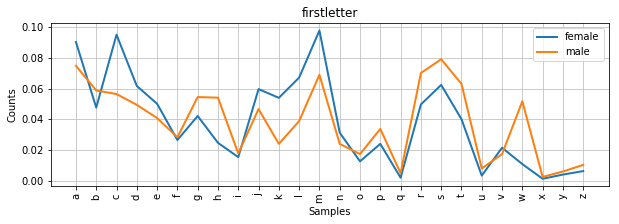

In [13]:
# firstletter
cfd_firstletter = nltk.ConditionalFreqDist(
    (gender, name[0].lower()) for name, gender in train_names)

# Normalize for male and female data
fem_count = float(len([gender for name, gender in train_names if gender == 'female']))
male_count = float(len([gender for name, gender in train_names if gender == 'male']))

for i in cfd_firstletter.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count
            
# define title
titleName='firstletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_firstletter.plot()

From the plot, we can observe that more female names begin with 'a', 'c', and 'm'

#### 2. Last Letter

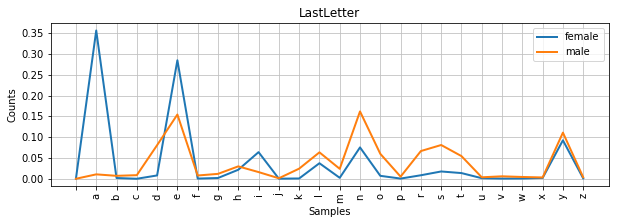

In [14]:
# lastletter
cfd_lastletter = nltk.ConditionalFreqDist(
    (gender, name[-1].lower()) for name, gender in train_names)

for i in cfd_lastletter.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

            
# define title
titleName='LastLetter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_lastletter.plot()

Names ending with letters 'a' and 'e' appear to be a good indicator of a female

#### 3. First 2 letters  

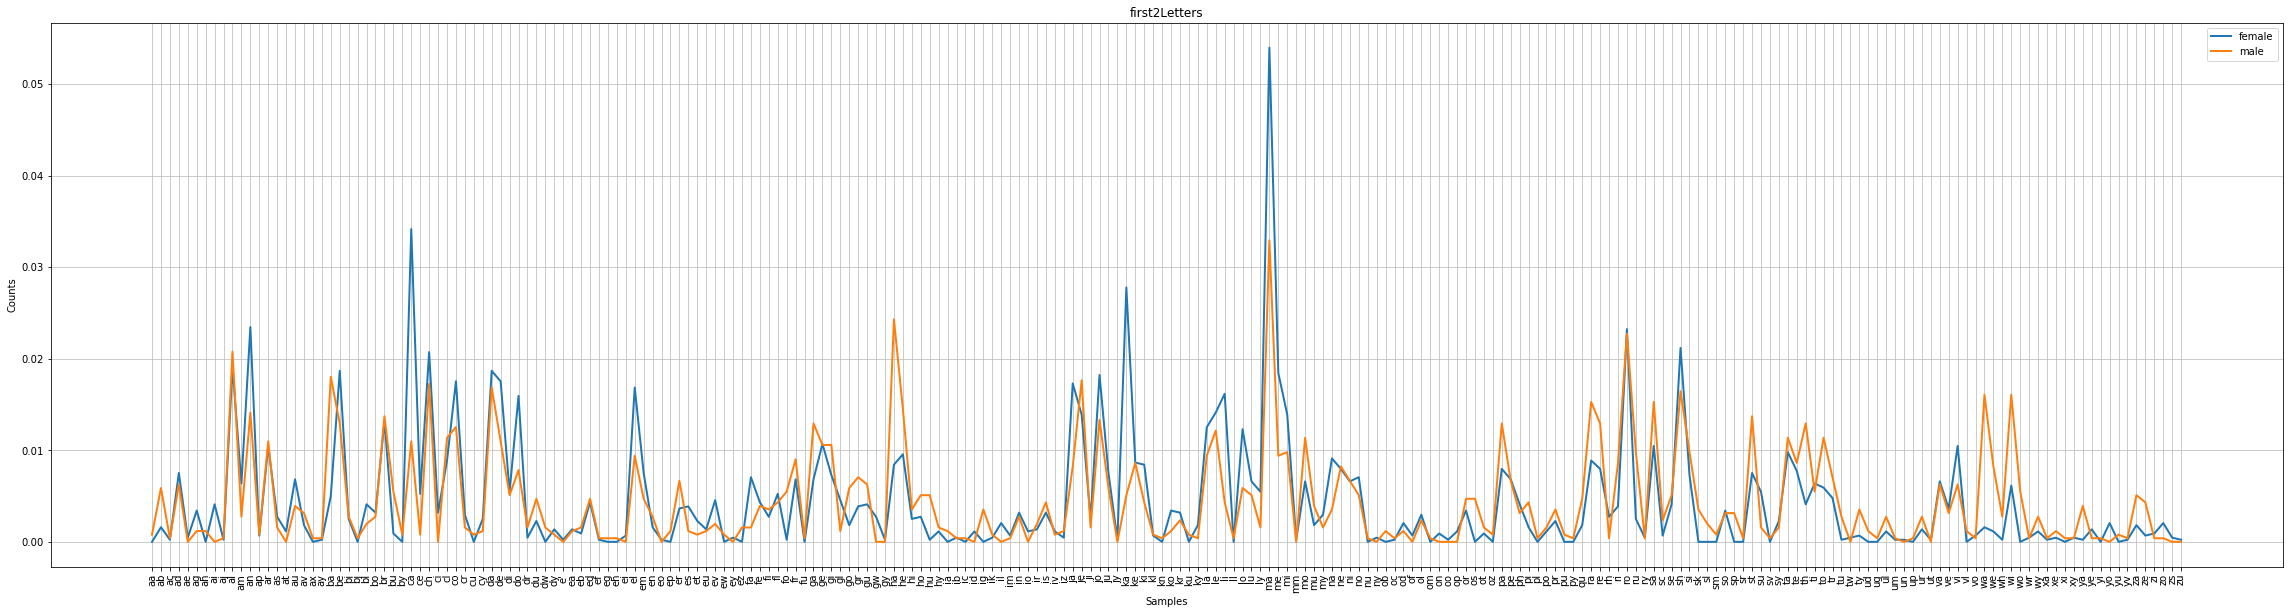

In [16]:
# first2Letters
cfd_first2Letters = nltk.ConditionalFreqDist(
    (gender, name[:2].lower()) for name, gender in train_names)

for i in cfd_first2Letters.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

# define title
titleName='first2Letters'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_first2Letters.plot()

There seems to be some deviation in the last two letters between male and female, We will explore this feature further as it is hard to decipher from the output.

#### 4. Length  

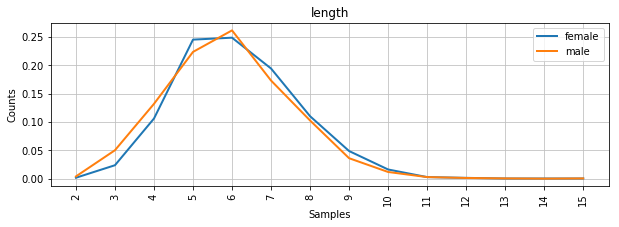

In [17]:
# length
cfd_length = nltk.ConditionalFreqDist(
    (gender, len(name)) for name, gender in train_names)

for i in cfd_length.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_length.plot()

The length does not appear to be a great indicator of gender on its own.

#### 5. Vowel Counts

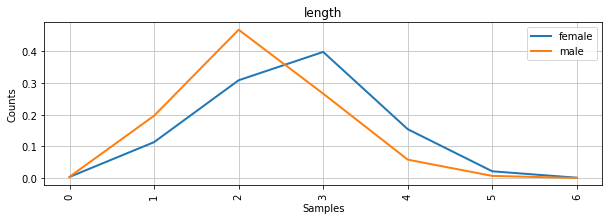

In [18]:
# Vowel Counts
cfd_vowels = nltk.ConditionalFreqDist(
    (gender, len(re.sub(r'[^aeiou]', '', name.lower()))) for name, gender in train_names)

for i in cfd_vowels.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_vowels.plot()

The females tend to have more vowels in their name over men.

### Exploratory Conclusions

The above observations of some features was a good starting point for feature selection, but these features do not appear to be good predictors of gender on their own; we need more advanced tools in order to build a good model. We will build a feature extractor for multiple features  and then use some introductory machine learning methods to create an optimum model.

### Feature Extractor Functions

This section below is to incrementally improve the feature extraction functions which are subsequently applied to the development and test datasets.  

Based on various example in the literature and analysis above, we will initiate our model building the following features:

1. First Letter, most names begining with a vowel are associated with females
2. First 2 letters
3. Last letter
4. Last 2 letters
5. Last 3 letters
6. Vowels count
7. Hard consonants using general rules of c and g
8. Soft consonants using general rules of c and g
9. Syllable Count of names via textstat
10. Name length
11. Character count
12. Character present
13. Count of each letter
14. Count of pair of letters in the alphabet

We built an function that will return a single feature or a combination of features based on input feature numbers


In [20]:
def get_features(name,feat_num):
    '''
    Parameters:
        name - string of name to extract feature
        feat_num - itterable collection of integers specifying features. *Defaults to 1:9 inclusive
            1: first letter
            2: first 2 letters
            3: last letter
            4: last 2 letters
            5: last 3 letters
            6: Vowel counts
            7: Hard consonant count
            8: Soft consonant count
            9: Syllable Count
            10: Name length
            11: char count --> feature for all alpha chars
            12: char present --> feature for all alpha chars (boolean)
            13: count each letter
            14: Count pairs
    Returns:
        features: a dictionary of extracted features
    '''
    features = {}    
        
    # Converts feat_num to itterable if type is int
    if type(feat_num) is int:
        feat_num = (0, feat_num)        
       
    # Gender Feature 1: First letter - book example
    if 1 in feat_num:
        features['firstletter'] = name[0].lower()
            
    # Gender Feature 2: First 2 letters
    if 2 in feat_num:
        features['first2Letters'] = name[0:2].lower()
            
    # Gender Feature 3: last letter
    if 3 in feat_num:
        features['last_letter'] = name[-1].lower()
            
    # Gender Feature 4: last 2 letter
    if 4 in feat_num:
        features["last2letters"] = name[-2:].lower()
        
    # Gender feature 5: last 3 letter
    if 5 in feat_num:  
        features["last3letters"] = name[-3:].lower()
            
    # Gender feature 6: Vowels count
    if 6 in feat_num:  
        features['vowel_count'] = len(re.sub(r'[^aeiou]', '', name.lower()))
            
    # Gender Feature 7: Hard consonants using general rules of c and g
    if 7 in feat_num:
        features['hard_consts'] = len(re.findall(r'[cg][^eiy]', name.lower()))/2
            
    # Gender Feature 8: Soft consonants using general rules of c and g
    if 8 in feat_num:
            features['soft_consts'] = len(re.findall(r'[cg][eiy]', name.lower()))/2
            
    # Gender Feature 9: Syllable Count of names via textstat
    if 9 in feat_num:
        features['syllable_count'] = textstat.syllable_count(name.lower())
    
    # Gender Feature 10: Name length
    if 10 in feat_num:
        features["length"] = len(name)
    
    # Gender Feature 11: Char Counts (overfitts)
    if 11 in feat_num:
        for letter in string.ascii_lowercase:
            features["count_{0}".format(letter)] = name.lower().count(letter)
                
    # Gender Feature 12: Char Booleans (overfitts)
    if 12 in feat_num:
        for letter in string.ascii_lowercase:
            features["has_{0}".format(letter)] = letter in name.lower()
        
        
    if 13 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter in letters:
            features["count(%s)" % letter] = name.lower().count(letter)


    if 14 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            for letter2 in letters:
                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())
        
    #### Complex Features
    # Gender Feature 15: Last Letter/Last 2 Letter
    if 15 in feat_num:
        features = {}
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
            
    if 16 in feat_num:
        features = {}
        features["firstletter"] = name[0].lower()
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
        features["last3letter"] = name[-3:].lower()

        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            features["count("+letter1+")"] = name.lower().count(letter1)
            features["has("+letter1+")"] = (letter1 in name.lower())
            # iterate over 2-grams
            for letter2 in letters:

                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())


    if 17 in feat_num:
        # define features
        features = {}
        # has(fo) = True
        features["has(fo)"] = ('fo' in name.lower())
        # has(hu) = True
        features["has(hu)"] = ('hu' in name.lower())
        # has(rv) = True
        features["has(rv)"] = ('rv' in name.lower())    
        # has(rw) = True
        features["has(rw)"] = ('rw' in name.lower()) 
        # has(sp) = True
        features["has(sp)"] = ('sp' in name.lower())

        # lastletter = 'a'
        features["lastletter=a"] = ('a' in name[-1:].lower())
        # lastletter = 'f'
        features["lastletter=f"] = ('f' in name[-1:].lower())
        # lastletter = 'k'
        features["lastletter=k"] = ('k' in name[-1:].lower())

        # last2letter = 'ch'
        features["last2letter=ch"] = ('ch' in name[-2:].lower())
        # last2letter = 'do'
        features["last2letter=do"] = ('do' in name[-2:].lower())
        # last2letter = 'ia'
        features["last2letter=ia"] = ('ia' in name[-2:].lower())
        # last2letter = 'im'
        features["last2letter=im"] = ('im' in name[-2:].lower())
        # last2letter = 'io'
        features["last2letter=io"] = ('io' in name[-2:].lower())
        # last2letter = 'la'
        features["last2letter=la"] = ('la' in name[-2:].lower())
        # last2letter = 'ld'
        features["last2letter=ld"] = ('ld' in name[-2:].lower())
        # last2letter = 'na'
        features["last2letter=na"] = ('na' in name[-2:].lower())
        # last2letter = 'os'
        features["last2letter=os"] = ('os' in name[-2:].lower())
        # last2letter = 'ra'
        features["last2letter=ra"] = ('ra' in name[-2:].lower())
        # last2letter = 'rd'
        features["last2letter=rd"] = ('rd' in name[-2:].lower())
        # last2letter = 'rt'
        features["last2letter=rt"] = ('rt' in name[-2:].lower())
        # last2letter = 'sa'
        features["last2letter=sa"] = ('sa' in name[-2:].lower())
        # last2letter = 'ta'
        features["last2letter=ta"] = ('ta' in name[-2:].lower())
        # last2letter = 'us'
        features["last2letter=us"] = ('us' in name[-2:].lower())

        # last3letter = 'ana'
        features["last3letter=ana"] = ('ana' in name[-3:].lower())    
        # last3letter = u'ard'
        features["last3letter=ard"] = ('ard' in name[-3:].lower())        
        # last3letter = u'ita'
        features["last3letter=ita"] = ('ita' in name[-3:].lower())    
        # last3letter = u'nne'
        features["last3letter=nne"] = ('nne' in name[-3:].lower())    
        # last3letter = u'tta'
        features["last3letter=tta"] = ('tta' in name[-3:].lower())    
        
    return features



In [24]:
get_features("Shyam",14)

{'has(aa)': False,
 'has(ab)': False,
 'has(ac)': False,
 'has(ad)': False,
 'has(ae)': False,
 'has(af)': False,
 'has(ag)': False,
 'has(ah)': False,
 'has(ai)': False,
 'has(aj)': False,
 'has(ak)': False,
 'has(al)': False,
 'has(am)': True,
 'has(an)': False,
 'has(ao)': False,
 'has(ap)': False,
 'has(aq)': False,
 'has(ar)': False,
 'has(as)': False,
 'has(at)': False,
 'has(au)': False,
 'has(av)': False,
 'has(aw)': False,
 'has(ax)': False,
 'has(ay)': False,
 'has(az)': False,
 'has(ba)': False,
 'has(bb)': False,
 'has(bc)': False,
 'has(bd)': False,
 'has(be)': False,
 'has(bf)': False,
 'has(bg)': False,
 'has(bh)': False,
 'has(bi)': False,
 'has(bj)': False,
 'has(bk)': False,
 'has(bl)': False,
 'has(bm)': False,
 'has(bn)': False,
 'has(bo)': False,
 'has(bp)': False,
 'has(bq)': False,
 'has(br)': False,
 'has(bs)': False,
 'has(bt)': False,
 'has(bu)': False,
 'has(bv)': False,
 'has(bw)': False,
 'has(bx)': False,
 'has(by)': False,
 'has(bz)': False,
 'has(ca)': F

### Functions for analysis and Helper functions

We built a few functions that will facilitate both the analysis and the display of the results:

+ normalize_confusion_matrix: Returns a normalized confusion matrix  
+ plot_confusion_matrix: plot a confusion matrix 
+ plot_both_confusion_matrix: plot 2 confusion matrix side by side  
+ evaluate_naive_bayes_classifier: train a model using naive bayes classifier  
+ evaluate_decision_tree_classifier: train a model using decision tree classifier
+ get_sorted_feature_accuracies: Returns a tuple of sorted features and accuracies in the dataset.
+ optimized_solution: Returns a tuple of list of features that yield the highest accuracy, and the accuracy that was achieved.

Helper functions:  

+ generate_errors
+ show_errors
+ generate_prediction

In [25]:
### Functions for analysis
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

def evaluate_naive_bayes_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set) 
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier

def evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.DecisionTreeClassifier.train(train_set)
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier
 
    
def get_sorted_feature_accuracies(feat_num_start, feat_num, model_id):
        feature_accuracy = {}
        for i in numpy.arange(feat_num_start, feat_num+1):
            feat_num =int(i)
            errors = []
            
            # devtest-set and training set are constructed
            #random.shuffle(development_set_names)
            #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
            train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
            devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
            test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names] 
            
            if (model_id == 'nbc'):
                classifier = nltk.NaiveBayesClassifier.train(train_set)
            elif (model_id == 'dtc'):
                classifier = nltk.DecisionTreeClassifier.train(train_set)
                  
            # For errors list
            for (name, tag) in devtest_names:
                guess = classifier.classify(get_features(name,feat_num)) 
                if guess != tag: 
                    errors.append((tag, guess, name))    
                    
            
            feature_accuracy[feat_num] = nltk.classify.accuracy(classifier, devtest_set)
        
        
        #sort for accuracy, and then reverse the array to return the array as most accurate to least accurate
        sorted_by_accuracy = sorted(feature_accuracy.items(), key=operator.itemgetter(1))
        return sorted_by_accuracy[::-1]
                  
def optimized_solution(model_id):
    # for each of the features, append to the list of features, and check if the accuracy
    #went up or down. If it went down, take it out, if it went up, make that the new accuracy to beat.
        
    optimized_feature_list = []
    last_accuracy = -1
    for feat_num in range(1,15):
        errors = []
        optimized_feature_list.append(feat_num)
            
        #random.shuffle(development_set_names)
        #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
        train_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in train_names]
        devtest_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in devtest_names]
        test_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in test_names] 
            
        if (model_id == 'nbc'):
            classifier = nltk.NaiveBayesClassifier.train(train_set)
        elif (model_id == 'dtc'):
            classifier = nltk.DecisionTreeClassifier.train(train_set) 
            
        for (name, tag) in devtest_names:
            guess = classifier.classify(get_features(name,optimized_feature_list)) 
            if guess != tag: 
                errors.append((tag, guess, name))    
                    
            
        current_accuracy= nltk.classify.accuracy(classifier, devtest_set)
        if current_accuracy > last_accuracy: 
            last_accuracy = current_accuracy
        else:
            del optimized_feature_list[-1]
            
    return (optimized_feature_list, last_accuracy)     

### Helper functions:

# Generic function to generate an error list based the arguments provided
# Accepts the classifer, names dataset, and the extractor function
# Returns the list of errors

def generate_errors(classifier, dataset, feat_num): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name,feat_num)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

# Generic function to display classification errors
# Accepts the error list and an optional argument to show only n number of errors

def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

        
def generate_prediction(classifier, dataset, extractor_function): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        classification.append((name,guess))
            
    return classification

### Gender Identification Models - Naive Bayes Classifier: 

We will evaluate how a Naive Bayes classifier performs for each of our previously identified simple feature sets.

#### Feature 1 - First Letter

In this model, we train a Naive Bayes classifier using a simple feature set - namely the first letter of the name.

Accuracy (Train): 0.6506336405529954
Accuracy (Development Test): 0.638


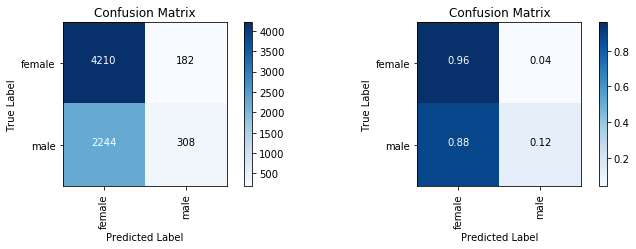

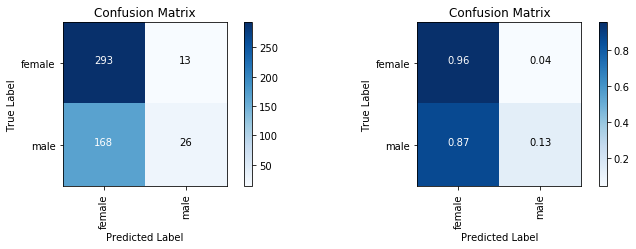

In [26]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb1,train_cm_nb1,train_label_names_nb1,train_report_nb1, \
    devtest_accuracy_nb1, devtest_cm_nb1,devtest_label_names_nb1, \
    devtest_report_nb1, classifier_nb1=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb1))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb1,['female','male'])

In [28]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb1)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6523    0.9586    0.7763      4392
       male     0.6286    0.1207    0.2025      2552

avg / total     0.6436    0.6506    0.5654      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6356    0.9575    0.7640       306
       male     0.6667    0.1340    0.2232       194

avg / total     0.6476    0.6380    0.5542       500



In [29]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb1.show_most_informative_features(n_informative_features)

Most Informative Features
             firstletter = 'w'              male : female =      4.8 : 1.0
             firstletter = 'q'              male : female =      2.5 : 1.0
             firstletter = 'u'              male : female =      2.4 : 1.0
             firstletter = 'k'            female : male   =      2.2 : 1.0
             firstletter = 'h'              male : female =      2.2 : 1.0
             firstletter = 'x'              male : female =      2.0 : 1.0
             firstletter = 'l'            female : male   =      1.7 : 1.0
             firstletter = 'c'            female : male   =      1.7 : 1.0
             firstletter = 'z'              male : female =      1.7 : 1.0
             firstletter = 't'              male : female =      1.6 : 1.0
             firstletter = 'y'              male : female =      1.5 : 1.0
             firstletter = 'm'            female : male   =      1.4 : 1.0
             firstletter = 'r'              male : female =      1.4 : 1.0

In [20]:
# Show error 
show_errors(generate_errors(classifier_nb1, devtest_names, feat_num))

correct=female   guess=male     name=Hannah                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Harli                         
correct=female   guess=male     name=Hatty                         
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Herta                         
correct=female   guess=male     name=Hilde                         
correct=female   guess=male     name=Hyacinthie                    
correct=female   guess=male     name=Quentin                       
correct=female   guess=male     name=Wilhelmine                    
correct=female   guess=male     name=Willabella                    
correct=female   guess=male     name=Willi                         
correct=female   guess=male     name=Wini                          
correct=female   guess=male     name=Yettie                        
correct=male     guess=female   name=Adlai      

First letter alone does not lead to very good results (~63% accuracy on test) as is indicated by the analysis above.

#### Feature 2 - First 2 letters  

We will now consider the first 2 letters as our feature.  


Accuracy (Train): 0.684907834101
Accuracy (Development Test): 0.672


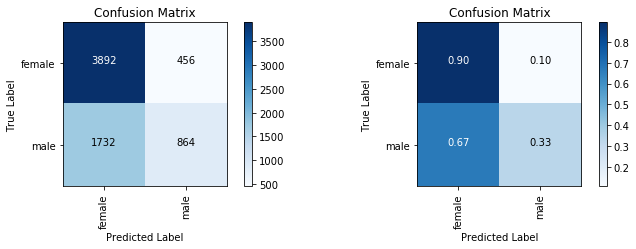

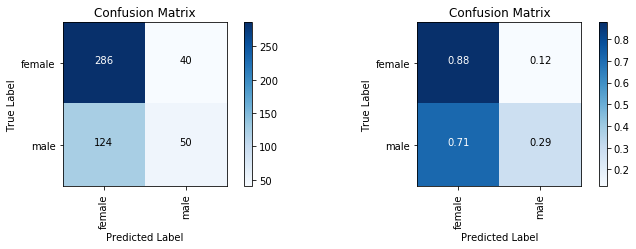

In [21]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb2,train_cm_nb2,train_label_names_nb2,train_report_nb2, \
    devtest_accuracy_nb2, devtest_cm_nb2,devtest_label_names_nb2, \
    devtest_report_nb2, classifier_nb2=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb2))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb2,['female','male'])

In [22]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb2)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb2)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6920    0.8951    0.7806      4348
       male     0.6545    0.3328    0.4413      2596

avg / total     0.6780    0.6849    0.6537      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6976    0.8773    0.7772       326
       male     0.5556    0.2874    0.3788       174

avg / total     0.6481    0.6720    0.6385       500



In [23]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb2.show_most_informative_features(n_informative_features)

Most Informative Features
           first2Letters = u'fo'            male : female =     15.9 : 1.0
           first2Letters = u'hu'            male : female =     13.7 : 1.0
           first2Letters = u'ya'            male : female =     12.6 : 1.0
           first2Letters = u'tu'            male : female =      9.3 : 1.0
           first2Letters = u'wa'            male : female =      8.6 : 1.0
           first2Letters = u'ce'          female : male   =      6.2 : 1.0
           first2Letters = u'ka'          female : male   =      6.1 : 1.0
           first2Letters = u'wh'            male : female =      6.0 : 1.0
           first2Letters = u'we'            male : female =      5.2 : 1.0
           first2Letters = u'fa'          female : male   =      5.1 : 1.0
           first2Letters = u'ty'            male : female =      4.9 : 1.0
           first2Letters = u'li'          female : male   =      4.6 : 1.0
           first2Letters = u'es'          female : male   =      4.3 : 1.0

In [24]:
# Show error 
show_errors(generate_errors(classifier_nb2, devtest_names, feat_num))

correct=female   guess=male     name=Babette                       
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Dulcinea                      
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gayleen                       
correct=female   guess=male     name=Gianina                       
correct=female   guess=male     name=Gilli                         
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Gisella                       
correct=female   guess=male     name=Giselle                       
correct=female   guess=male     name=Grazia                        
correct=female   guess=male     name=Greta                         
correct=female   guess=male     name=Grethel                       
correct=female   guess=male     name=Hannah     

The first letter feature set stand-alone performance is also relatively low.

#### Feature 3 - Last letter

We will now focus on the last letter of the name. In our brief exploration of features, we observed some patterns that could likely be exploited by our classifier.

Accuracy (Train): 0.760512672811
Accuracy (Development Test): 0.762


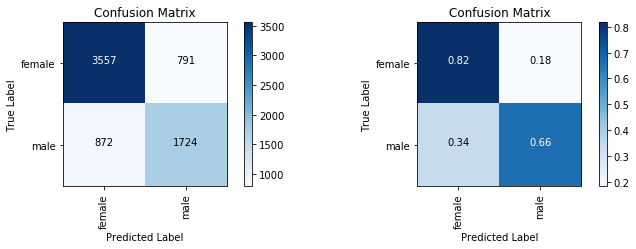

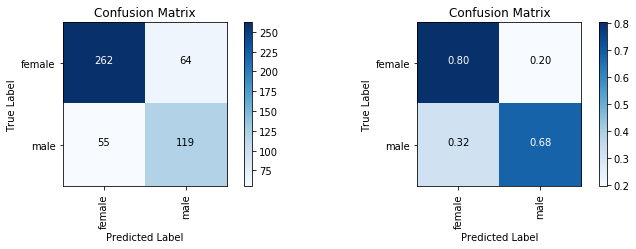

In [25]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb3,train_cm_nb3,train_label_names_nb3,train_report_nb3, \
    devtest_accuracy_nb3, devtest_cm_nb3,devtest_label_names_nb3, \
    devtest_report_nb3, classifier_nb3=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb3))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb3,['female','male'])

In [130]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb3)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb3)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8031    0.8181    0.8105      4348
       male     0.6855    0.6641    0.6746      2596

avg / total     0.7591    0.7605    0.7597      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8265    0.8037    0.8149       326
       male     0.6503    0.6839    0.6667       174

avg / total     0.7652    0.7620    0.7633       500



In [26]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb3.show_most_informative_features(n_informative_features)

Most Informative Features
             last_letter = u'k'             male : female =     39.8 : 1.0
             last_letter = u'a'           female : male   =     32.2 : 1.0
             last_letter = u'f'             male : female =     15.0 : 1.0
             last_letter = u'v'             male : female =     11.0 : 1.0
             last_letter = u'm'             male : female =      9.8 : 1.0
             last_letter = u'd'             male : female =      9.8 : 1.0
             last_letter = u'p'             male : female =      9.7 : 1.0
             last_letter = u'o'             male : female =      8.2 : 1.0
             last_letter = u'r'             male : female =      6.6 : 1.0
             last_letter = u'g'             male : female =      5.6 : 1.0
             last_letter = u'w'             male : female =      5.0 : 1.0
             last_letter = u'z'             male : female =      4.5 : 1.0
             last_letter = u's'             male : female =      4.2 : 1.0

In [27]:
show_errors(generate_errors(classifier_nb3, devtest_names, feat_num))

correct=female   guess=male     name=Ailyn                         
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Eilis                         
correct=female   guess=male     name=Ellen                         
correct=female   guess=male     name=Eryn       

Although names ending in the letter 'a' is our second best feature in this feature set, the other rules that looked useful in gender prediction were not in the top of the list.

#### Feature 4 - Last 2 letters  

In this model, we train a Naive Bayes classifier using a feature set comprised of the first two letters of a name.

Accuracy (Train): 0.802419354839
Accuracy (Development Test): 0.786


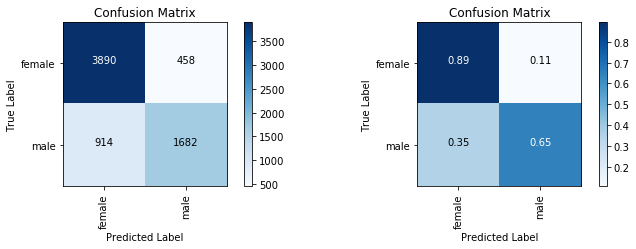

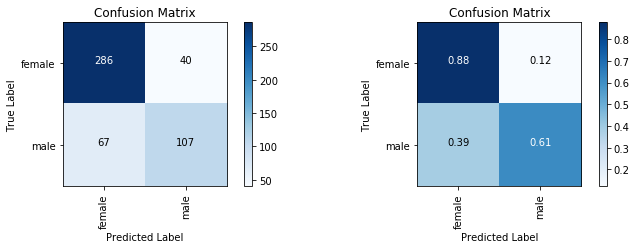

In [28]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb4,train_cm_nb4,train_label_names_nb4,train_report_nb4, \
    devtest_accuracy_nb4, devtest_cm_nb4,devtest_label_names_nb4, \
    devtest_report_nb4, classifier_nb4=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb4))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb4,['female','male'])

In [136]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb4)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb4)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8097    0.8947    0.8501      4348
       male     0.7860    0.6479    0.7103      2596

avg / total     0.8009    0.8024    0.7978      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8102    0.8773    0.8424       326
       male     0.7279    0.6149    0.6667       174

avg / total     0.7816    0.7860    0.7813       500



In [29]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb4.show_most_informative_features(n_informative_features)

Most Informative Features
            last2letters = u'na'          female : male   =     93.4 : 1.0
            last2letters = u'la'          female : male   =     70.0 : 1.0
            last2letters = u'ia'          female : male   =     38.9 : 1.0
            last2letters = u'ra'          female : male   =     34.0 : 1.0
            last2letters = u'sa'          female : male   =     33.9 : 1.0
            last2letters = u'rt'            male : female =     28.6 : 1.0
            last2letters = u'us'            male : female =     27.9 : 1.0
            last2letters = u'ld'            male : female =     23.3 : 1.0
            last2letters = u'ta'          female : male   =     22.9 : 1.0
            last2letters = u'rd'            male : female =     22.8 : 1.0
            last2letters = u'os'            male : female =     18.1 : 1.0
            last2letters = u'im'            male : female =     17.0 : 1.0
            last2letters = u'io'            male : female =     16.1 : 1.0

In [30]:
# Show error 
show_errors(generate_errors(classifier_nb4, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Ange                          
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Jacquelin  

Feature utilizating last letter(s) leads better results so far.  

#### Feature 5 - Last 3 Letters  

In this model, we train a Naive Bayes classifier using the last three letters of the name.

Accuracy (Train): 0.857430875576
Accuracy (Development Test): 0.768


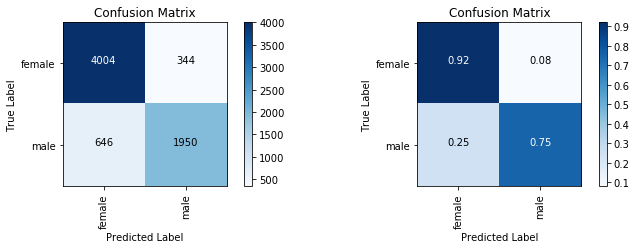

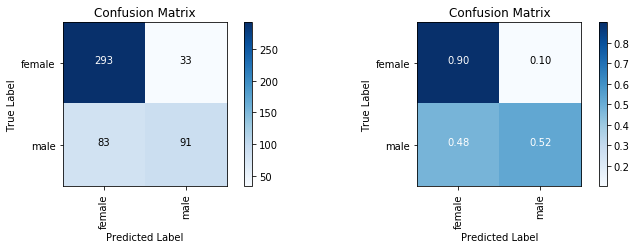

In [31]:
feat_num = 5
# evaluate the Naive Bayes classifier using gender_features5
train_accuracy_nb5,train_cm_nb5,train_label_names_nb5,train_report_nb5, \
    devtest_accuracy_nb5, devtest_cm_nb5,devtest_label_names_nb5, \
    devtest_report_nb5, classifier_nb5=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb5))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb5,['female','male'])

In [137]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb5)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb5)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8611    0.9209    0.8900      4348
       male     0.8500    0.7512    0.7975      2596

avg / total     0.8570    0.8574    0.8554      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7793    0.8988    0.8348       326
       male     0.7339    0.5230    0.6107       174

avg / total     0.7635    0.7680    0.7568       500



In [32]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb5.show_most_informative_features(n_informative_features)

Most Informative Features
            last3letters = u'nne'         female : male   =     28.8 : 1.0
            last3letters = u'ana'         female : male   =     24.1 : 1.0
            last3letters = u'tta'         female : male   =     22.8 : 1.0
            last3letters = u'ard'           male : female =     20.0 : 1.0
            last3letters = u'old'           male : female =     16.9 : 1.0
            last3letters = u'ert'           male : female =     15.7 : 1.0
            last3letters = u'ita'         female : male   =     15.0 : 1.0
            last3letters = u'ela'         female : male   =     14.1 : 1.0
            last3letters = u'dra'         female : male   =     12.8 : 1.0
            last3letters = u'ria'         female : male   =     12.8 : 1.0
            last3letters = u'vin'           male : female =     12.0 : 1.0
            last3letters = u'son'           male : female =     10.4 : 1.0
            last3letters = u'nni'         female : male   =      9.8 : 1.0

In [33]:
# Show error 
show_errors(generate_errors(classifier_nb5, devtest_names, feat_num))

correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Carey                         
correct=female   guess=male     name=Carole                        
correct=female   guess=male     name=Dale                          
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Jan                           
correct=female   guess=male     name=Jenn                          
correct=female   guess=male     name=Jillian                       
correct=female   guess=male     name=Joell                         
correct=female   guess=male     name=Jorey                         
correct=female   guess=male     name=Kiersten   

The last 3 letters is not as good as the last 2.

#### Feature 6 - Vowels Count  

In this model, we train a Naive Bayes classifier using the vowel count.

Accuracy (Train): 0.628456221198
Accuracy (Development Test): 0.658


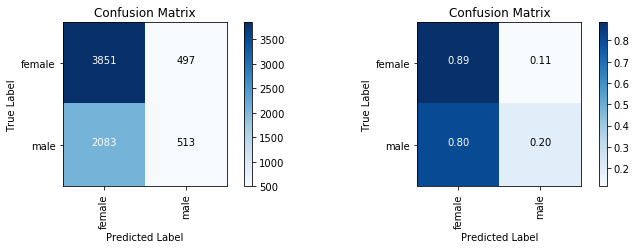

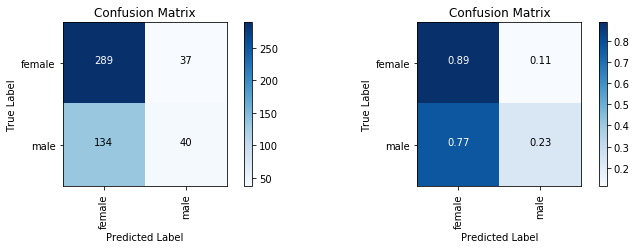

In [34]:
feat_num = 6
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb6,train_cm_nb6,train_label_names_nb6,train_report_nb6, \
    devtest_accuracy_nb6, devtest_cm_nb6,devtest_label_names_nb6, \
    devtest_report_nb6, classifier_nb6=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb6))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb6,['female','male'])

In [138]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb6)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb6)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6490    0.8857    0.7491      4348
       male     0.5079    0.1976    0.2845      2596

avg / total     0.5962    0.6285    0.5754      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6832    0.8865    0.7717       326
       male     0.5195    0.2299    0.3187       174

avg / total     0.6262    0.6580    0.6141       500



In [35]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb6.show_most_informative_features(n_informative_features)

Most Informative Features
             vowel_count = 5              female : male   =      3.2 : 1.0
             vowel_count = 4              female : male   =      2.5 : 1.0
             vowel_count = 1                male : female =      1.7 : 1.0
             vowel_count = 3              female : male   =      1.5 : 1.0
             vowel_count = 2                male : female =      1.5 : 1.0
             vowel_count = 0                male : female =      1.3 : 1.0


In [36]:
# Show error 
show_errors(generate_errors(classifier_nb6, devtest_names, feat_num))

correct=female   guess=male     name=Anny                          
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Deny                          
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Eryn                          
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Hatty                         
correct=female   guess=male     name=Jan        

This feature does not appear to be a good indicator.

#### Feature 7 - Hard Consonant using general rules of c and g  

In this model, we train a Naive Bayes classifier based on hard consonants using general rules of 'c' and 'g'.

Accuracy (Train): 0.626440092166
Accuracy (Development Test): 0.654


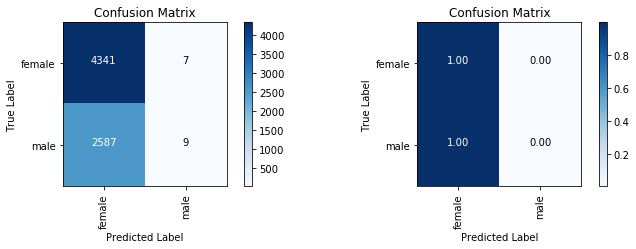

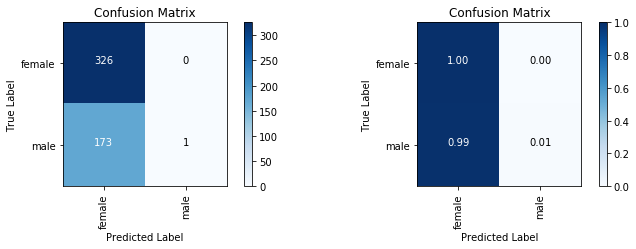

In [37]:
feat_num = 7
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb7,train_cm_nb7,train_label_names_nb7,train_report_nb7, \
    devtest_accuracy_nb7, devtest_cm_nb7,devtest_label_names_nb7, \
    devtest_report_nb7, classifier_nb7=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb7))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb7,['female','male'])

In [139]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb7)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb7)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6266    0.9984    0.7700      4348
       male     0.5625    0.0035    0.0069      2596

avg / total     0.6026    0.6264    0.4847      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6533    1.0000    0.7903       326
       male     1.0000    0.0057    0.0114       174

avg / total     0.7740    0.6540    0.5193       500



In [38]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb7.show_most_informative_features(n_informative_features)

Most Informative Features
             hard_consts = 1                male : female =      2.1 : 1.0
             hard_consts = 0              female : male   =      1.0 : 1.0


In [39]:
# Show error 
show_errors(generate_errors(classifier_nb7, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

Again, this feature does not look promising as a first feature to build our model on.  

#### Feature 8 - Soft Consonant using general rules of c and g  

In this model, we train a Naive Bayes classifier based on soft consonants using general rules of 'c' and 'g'.

C:\Users\Derek\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


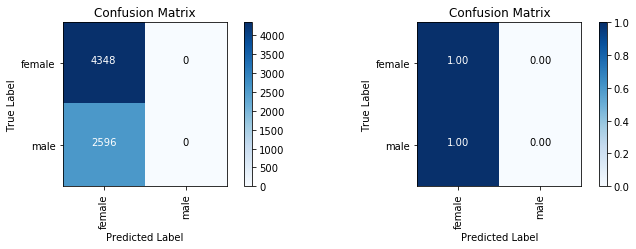

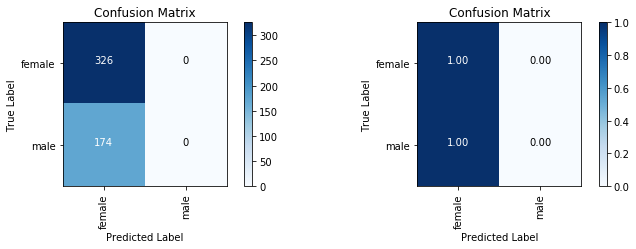

In [40]:
feat_num = 8
# evaluate the Naive Bayes classifier using gender_features8
train_accuracy_nb8,train_cm_nb8,train_label_names_nb8,train_report_nb8, \
    devtest_accuracy_nb8, devtest_cm_nb8,devtest_label_names_nb8, \
    devtest_report_nb8, classifier_nb8=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb8))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb8,['female','male'])

In [140]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb8)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb8)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6262    1.0000    0.7701      4348
       male     0.0000    0.0000    0.0000      2596

avg / total     0.3921    0.6262    0.4822      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6520    1.0000    0.7893       326
       male     0.0000    0.0000    0.0000       174

avg / total     0.4251    0.6520    0.5147       500



In [41]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb8.show_most_informative_features(n_informative_features)

Most Informative Features
             soft_consts = 1              female : male   =      2.0 : 1.0
             soft_consts = 0                male : female =      1.0 : 1.0


In [42]:
# Show error 
show_errors(generate_errors(classifier_nb8, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

#### Feature 9 - Syllable Count  

In this model, we train a Naive Bayes classifier using the syllable count.

Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


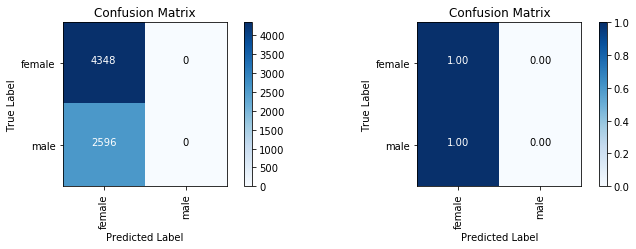

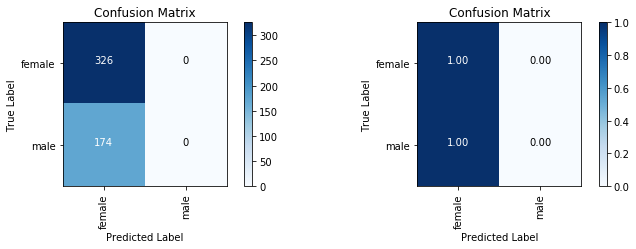

In [43]:
feat_num = 9
# evaluate the Naive Bayes classifier using gender_features9
train_accuracy_nb9,train_cm_nb9,train_label_names_nb9,train_report_nb9, \
    devtest_accuracy_nb9, devtest_cm_nb9,devtest_label_names_nb9, \
    devtest_report_nb9, classifier_nb9=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb9))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb9,['female','male'])

In [141]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb9)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb9)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6262    1.0000    0.7701      4348
       male     0.0000    0.0000    0.0000      2596

avg / total     0.3921    0.6262    0.4822      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6520    1.0000    0.7893       326
       male     0.0000    0.0000    0.0000       174

avg / total     0.4251    0.6520    0.5147       500



In [44]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb9.show_most_informative_features(n_informative_features)

Most Informative Features
          syllable_count = 3.6            female : male   =      3.1 : 1.0
          syllable_count = 2.7            female : male   =      2.0 : 1.0
          syllable_count = 0.9              male : female =      1.5 : 1.0
          syllable_count = 1.8              male : female =      1.2 : 1.0


In [45]:
# Show error 
show_errors(generate_errors(classifier_nb9, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

The syllable count does not appear to be a good indicator.

#### Feature 10 - Name Length  

In this model, we train a Naive Bayes classifier using the name length.

Accuracy (Train): 0.628744239631
Accuracy (Development Test): 0.66


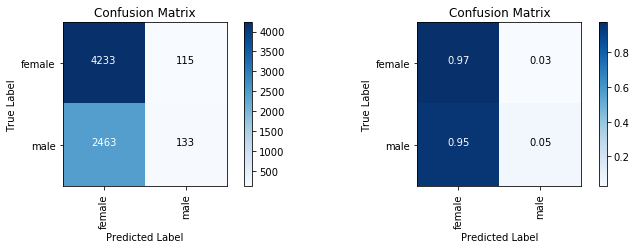

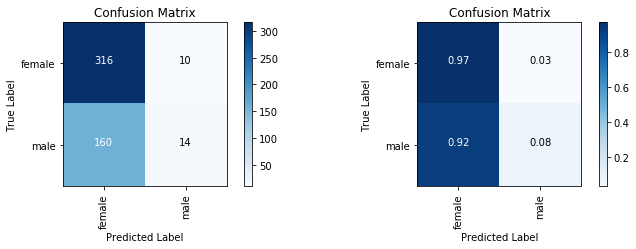

In [46]:
feat_num = 10
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb10,train_cm_nb10,train_label_names_nb10,train_report_nb10, \
    devtest_accuracy_nb10, devtest_cm_nb10,devtest_label_names_nb10, \
    devtest_report_nb10, classifier_nb10=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb10))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb10,['female','male'])

In [142]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb10)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb10)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6322    0.9736    0.7666      4348
       male     0.5363    0.0512    0.0935      2596

avg / total     0.5963    0.6287    0.5150      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6639    0.9693    0.7880       326
       male     0.5833    0.0805    0.1414       174

avg / total     0.6358    0.6600    0.5630       500



In [47]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb10.show_most_informative_features(n_informative_features)

Most Informative Features
                  length = 2                male : female =      2.1 : 1.0
                  length = 3                male : female =      1.9 : 1.0
                  length = 15               male : female =      1.7 : 1.0
                  length = 9              female : male   =      1.4 : 1.0
                  length = 10             female : male   =      1.4 : 1.0
                  length = 12               male : female =      1.4 : 1.0
                  length = 4                male : female =      1.2 : 1.0
                  length = 7              female : male   =      1.1 : 1.0
                  length = 8              female : male   =      1.1 : 1.0
                  length = 6                male : female =      1.1 : 1.0
                  length = 5              female : male   =      1.1 : 1.0
                  length = 11             female : male   =      1.0 : 1.0
                  length = 13               male : female =      1.0 : 1.0

In [48]:
# Show error 
show_errors(generate_errors(classifier_nb10, devtest_names, feat_num))

correct=female   guess=male     name=Jan                           
correct=female   guess=male     name=Kay                           
correct=female   guess=male     name=Kia                           
correct=female   guess=male     name=Lee                           
correct=female   guess=male     name=Mag                           
correct=female   guess=male     name=May                           
correct=female   guess=male     name=Pam                           
correct=female   guess=male     name=Pen                           
correct=female   guess=male     name=Pet                           
correct=female   guess=male     name=Tim                           
correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford     

Nae length is not a good indicator

#### Feature 11 - Character Count  

In this model, we train a Naive Bayes classifier using a character count.  

Accuracy (Train): 0.708093317972
Accuracy (Development Test): 0.712


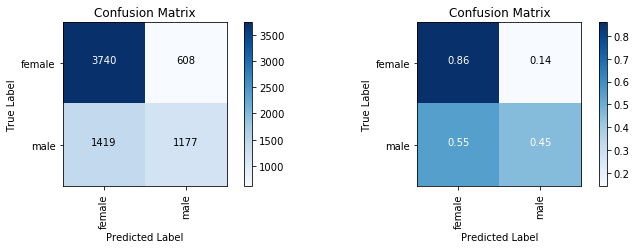

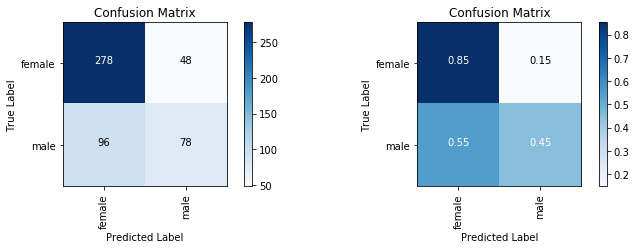

In [49]:
feat_num = 11
# evaluate the Naive Bayes classifier using gender_features11
train_accuracy_nb11,train_cm_nb11,train_label_names_nb11,train_report_nb11, \
    devtest_accuracy_nb11, devtest_cm_nb11,devtest_label_names_nb11, \
    devtest_report_nb11, classifier_nb11=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb11))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb11))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb11,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb11,['female','male'])

In [143]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb11)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb11)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7249    0.8602    0.7868      4348
       male     0.6594    0.4534    0.5373      2596

avg / total     0.7004    0.7081    0.6935      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7433    0.8528    0.7943       326
       male     0.6190    0.4483    0.5200       174

avg / total     0.7001    0.7120    0.6988       500



In [50]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb11.show_most_informative_features(n_informative_features)

Most Informative Features
                 count_v = 2              female : male   =      8.6 : 1.0
                 count_w = 1                male : female =      4.6 : 1.0
                 count_a = 3              female : male   =      4.5 : 1.0
                 count_k = 2              female : male   =      3.7 : 1.0
                 count_o = 2                male : female =      3.6 : 1.0
                 count_f = 2                male : female =      3.4 : 1.0
                 count_l = 3              female : male   =      3.3 : 1.0
                 count_i = 3                male : female =      3.1 : 1.0
                 count_a = 2              female : male   =      3.0 : 1.0
                 count_d = 3                male : female =      2.8 : 1.0
                 count_e = 3              female : male   =      2.8 : 1.0
                 count_p = 3              female : male   =      2.6 : 1.0
                 count_w = 2                male : female =      2.3 : 1.0

In [51]:
# Show error 
show_errors(generate_errors(classifier_nb11, devtest_names, feat_num))

correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Cherri                        
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Correna                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Dee Dee                       
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Dorolisa                      
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Fortune    

Character count does a bit better than the past few previous features, but is not in the top performing features.

#### Feature 12 - Character Present  

In this model, we train a Naive Bayes classifier using a binary flag indicating that a letter is present.

Accuracy (Train): 0.690668202765
Accuracy (Development Test): 0.718


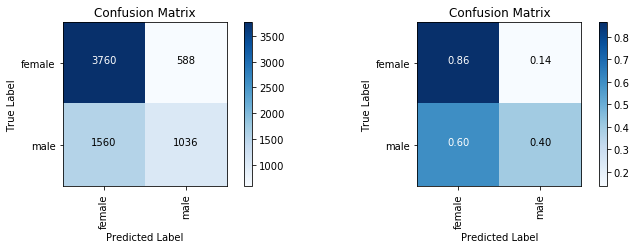

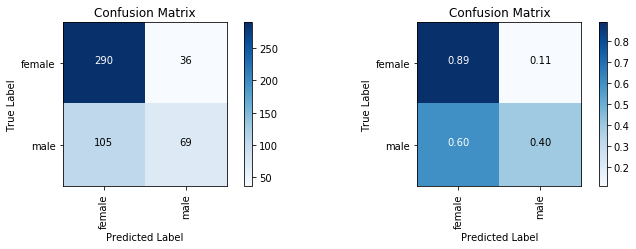

In [52]:
feat_num = 12
# evaluate the Naive Bayes classifier using gender_features12
train_accuracy_nb12,train_cm_nb12,train_label_names_nb12,train_report_nb12, \
    devtest_accuracy_nb12, devtest_cm_nb12,devtest_label_names_nb12, \
    devtest_report_nb12, classifier_nb12=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb12))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb12))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb12,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb12,['female','male'])

In [144]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb12)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb12)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7068    0.8648    0.7778      4348
       male     0.6379    0.3991    0.4910      2596

avg / total     0.6810    0.6907    0.6706      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7342    0.8896    0.8044       326
       male     0.6571    0.3966    0.4946       174

avg / total     0.7074    0.7180    0.6966       500



In [53]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb12.show_most_informative_features(n_informative_features)

Most Informative Features
                   has_w = True             male : female =      4.6 : 1.0
                   has_u = True             male : female =      1.8 : 1.0
                   has_p = True             male : female =      1.8 : 1.0
                   has_f = True             male : female =      1.6 : 1.0
                   has_o = True             male : female =      1.6 : 1.0
                   has_g = True             male : female =      1.5 : 1.0
                   has_a = False            male : female =      1.5 : 1.0
                   has_z = True             male : female =      1.4 : 1.0
                   has_i = True           female : male   =      1.4 : 1.0
                   has_h = True             male : female =      1.4 : 1.0
                   has_v = True             male : female =      1.4 : 1.0
                   has_a = True           female : male   =      1.3 : 1.0
                   has_i = False            male : female =      1.3 : 1.0

In [54]:
# Show error 
show_errors(generate_errors(classifier_nb12, devtest_names, feat_num))

correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gertruda                      
correct=female   guess=male     name=Grethel                       
correct=female   guess=male     name=Gypsy                         
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Johnette                      
correct=female   guess=male     name=Jorey                         
correct=female   guess=male     name=Jorry      

Testing if a letter is present is not a good indicator.

#### Feature 13 - Count of each letter   

In this model, we train a Naive Bayes classifier using the count of each letter.

Accuracy (Train): 0.708093317972
Accuracy (Development Test): 0.712


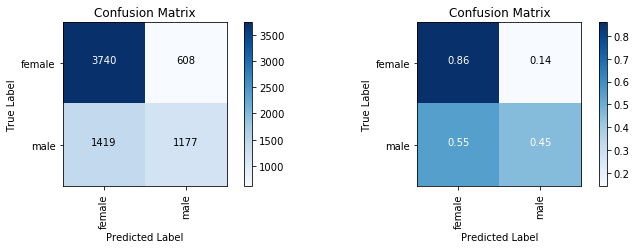

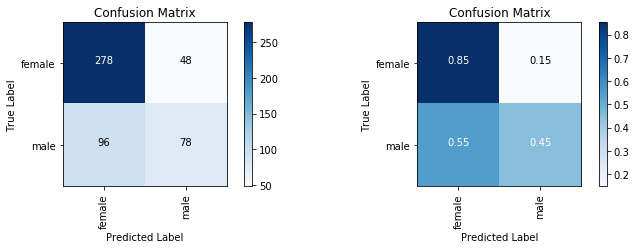

In [55]:
feat_num = 13
# evaluate the Naive Bayes classifier using gender_features13
train_accuracy_nb13,train_cm_nb13,train_label_names_nb13,train_report_nb13, \
    devtest_accuracy_nb13, devtest_cm_nb13,devtest_label_names_nb13, \
    devtest_report_nb13, classifier_nb13=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb13))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb13))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb13,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb13,['female','male'])

In [131]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb13)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb13)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7249    0.8602    0.7868      4348
       male     0.6594    0.4534    0.5373      2596

avg / total     0.7004    0.7081    0.6935      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7433    0.8528    0.7943       326
       male     0.6190    0.4483    0.5200       174

avg / total     0.7001    0.7120    0.6988       500



In [56]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb13.show_most_informative_features(n_informative_features)

Most Informative Features
                count(v) = 2              female : male   =      8.6 : 1.0
                count(w) = 1                male : female =      4.6 : 1.0
                count(a) = 3              female : male   =      4.5 : 1.0
                count(k) = 2              female : male   =      3.7 : 1.0
                count(o) = 2                male : female =      3.6 : 1.0
                count(f) = 2                male : female =      3.4 : 1.0
                count(l) = 3              female : male   =      3.3 : 1.0
                count(i) = 3                male : female =      3.1 : 1.0
                count(a) = 2              female : male   =      3.0 : 1.0
                count(d) = 3                male : female =      2.8 : 1.0
                count(e) = 3              female : male   =      2.8 : 1.0
                count(p) = 3              female : male   =      2.6 : 1.0
                count(w) = 2                male : female =      2.3 : 1.0

In [57]:
# Show error 
show_errors(generate_errors(classifier_nb13, devtest_names, feat_num))

correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Cherri                        
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Correna                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Dee Dee                       
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Dorolisa                      
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Fortune    

Decent performance by character count, but still not one of the top performers.

#### Feature 14 - Count of Pair of letters  

In this model, we train a Naive Bayes classifier using the count of pair of letters.

Accuracy (Train): 0.759648617512
Accuracy (Development Test): 0.76


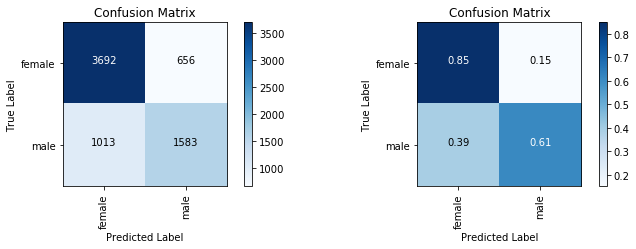

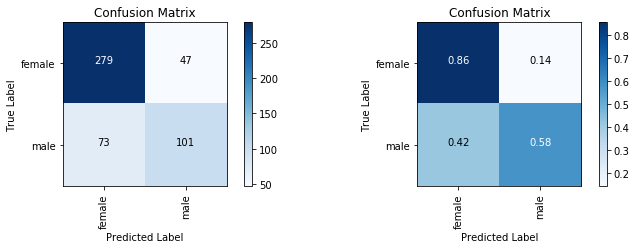

In [58]:
feat_num = 14
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb14,train_cm_nb14,train_label_names_nb14,train_report_nb14, \
    devtest_accuracy_nb14, devtest_cm_nb14,devtest_label_names_nb14, \
    devtest_report_nb14, classifier_nb14=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb14))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb14))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb14,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb14,['female','male'])

In [145]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb14)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb14)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7847    0.8491    0.8156      4348
       male     0.7070    0.6098    0.6548      2596

avg / total     0.7557    0.7596    0.7555      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7926    0.8558    0.8230       326
       male     0.6824    0.5805    0.6273       174

avg / total     0.7543    0.7600    0.7549       500



In [59]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb14.show_most_informative_features(n_informative_features)

Most Informative Features
                 has(fo) = True             male : female =     34.1 : 1.0
                 has(rk) = True             male : female =     24.0 : 1.0
                 has(hu) = True             male : female =     22.4 : 1.0
                 has(iu) = True             male : female =     17.3 : 1.0
                 has(rw) = True             male : female =     15.1 : 1.0
                 has(sp) = True             male : female =     14.0 : 1.0
                 has(lt) = True             male : female =     13.1 : 1.0
                 has(tc) = True             male : female =     12.8 : 1.0
                 has(wa) = True             male : female =     10.3 : 1.0
                 has(cu) = True             male : female =      9.5 : 1.0
                 has(ew) = True             male : female =      8.7 : 1.0
                 has(sk) = True             male : female =      7.7 : 1.0
                 has(wh) = True             male : female =      6.1 : 1.0

In [60]:
# Show error 
show_errors(generate_errors(classifier_nb14, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Alberta                       
correct=female   guess=male     name=Ange                          
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Berta                         
correct=female   guess=male     name=Cherri                        
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Eddi                          
correct=female   guess=male     name=Emera                         
correct=female   guess=male     name=Esmerelda                     
correct=female   guess=male     name=Fedora     

Decent performance for letter pairs present, but not the best. This creates 26^2 features as a result and is very computationally intensive.

### Features Optimization    

In order to build the best possible Naive Baeyes Module, we will identify the best features based on accuracy rating.  


In [61]:
ranked_features = get_sorted_feature_accuracies(1, 14, 'nbc')

In [62]:
features = {
    1: "First Letter",
    2: "First 2 Letters",
    3: "Last Letter", 
    4: "Last 2 Letters", 
    5: "Last 3 Letters", 
    6: "Vowels count",
    7: "Hard consonants using general rules of c and g",
    8: "Soft consonants using general rules of c and g",
    9: "Syllable Count of names via textstat",
    10: "Name length",
    11: "Character count",
    12: "Character present",
    13: "Count of each letter",
    14: "Count of pair of letters in the alphabet",
}

print("Top Five Single Features with the Highest Accuracy")
print("---------------------------------------------------------------")
for (feat_num, accuracy) in ranked_features[0:5]:
    print('Feature: %-30s Accuracy: %-8s' %(features[feat_num], accuracy))

print("---------------------------------------------------------------")

Top Five Single Features with the Highest Accuracy
---------------------------------------------------------------
Feature: Last 2 Letters                 Accuracy: 0.786   
Feature: Last 3 Letters                 Accuracy: 0.768   
Feature: Last Letter                    Accuracy: 0.762   
Feature: Count of pair of letters in the alphabet Accuracy: 0.76    
Feature: Character present              Accuracy: 0.718   
---------------------------------------------------------------


Combining different features together can often lead to a more accurate classification system. The optmize_solution function was built to go through different combinations of classification features, and yield out a result of features that lead to the most accurate solution:

In [63]:
optimized_features = optimized_solution('nbc')
optimized_features


([1, 3, 4, 5, 6, 11], 0.83)

We see that the optmized solution yielded an accuracy of 0.83, while the highest accuracy achieved by any single feature was 0.786. The following features provided the optimized solution:

In [64]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

Following features provide the most optmized solution: 
    -> First Letter                  
    -> Last Letter                   
    -> Last 2 Letters                
    -> Last 3 Letters                
    -> Vowels count                  
    -> Character count               


#### Complex Feature Set Evaluation

Based on the single feature set evaluations performed above, we developed some more complex feature sets combining feature set generation rules. These more complex feature sets are evaluated below.

##### Feature 15 - Last Letter / Last 2 Letter  

In this model, we train a Naive Bayes classifier using the last letter of the name and the last two letters of the name.

Accuracy (Train): 0.787730414747
Accuracy (Development Test): 0.786


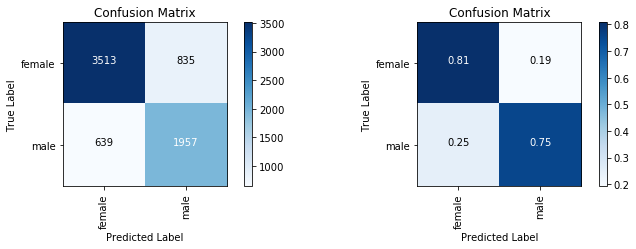

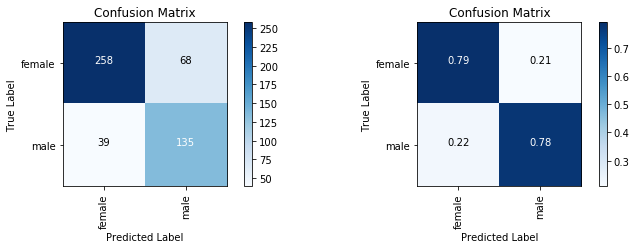

In [65]:
feat_num = 15
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb15,train_cm_nb15,train_label_names_nb15,train_report_nb15, \
    devtest_accuracy_nb15, devtest_cm_nb15,devtest_label_names_nb15, \
    devtest_report_nb15, classifier_nb15=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb15))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb15))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb15,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb15,['female','male'])

In [135]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb15)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb15)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8461    0.8080    0.8266      4348
       male     0.7009    0.7539    0.7264      2596

avg / total     0.7918    0.7877    0.7891      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8687    0.7914    0.8283       326
       male     0.6650    0.7759    0.7162       174

avg / total     0.7978    0.7860    0.7893       500



In [66]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb15.show_most_informative_features(n_informative_features)

Most Informative Features
             last2letter = u'na'          female : male   =     93.4 : 1.0
             last2letter = u'la'          female : male   =     70.0 : 1.0
              lastletter = u'k'             male : female =     39.8 : 1.0
             last2letter = u'ia'          female : male   =     38.9 : 1.0
             last2letter = u'ra'          female : male   =     34.0 : 1.0
             last2letter = u'sa'          female : male   =     33.9 : 1.0
              lastletter = u'a'           female : male   =     32.2 : 1.0
             last2letter = u'rt'            male : female =     28.6 : 1.0
             last2letter = u'us'            male : female =     27.9 : 1.0
             last2letter = u'ld'            male : female =     23.3 : 1.0
             last2letter = u'ta'          female : male   =     22.9 : 1.0
             last2letter = u'rd'            male : female =     22.8 : 1.0
             last2letter = u'os'            male : female =     18.1 : 1.0

In [67]:
# Show error 
show_errors(generate_errors(classifier_nb15, devtest_names, feat_num))

correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Britney                       
correct=female   guess=male     name=Carey                         
correct=female   guess=male     name=Casey                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido       

##### Feature 16 - Complex Combine Feature

In this model, we train a Naive Bayes classifier using a feature set composed of the first letter, the last letter, the last two letters, the last 3 letters, the letter count, the presence of a letter, and all two letter combinations.

Accuracy (Train): 0.837269585253
Accuracy (Development Test): 0.824


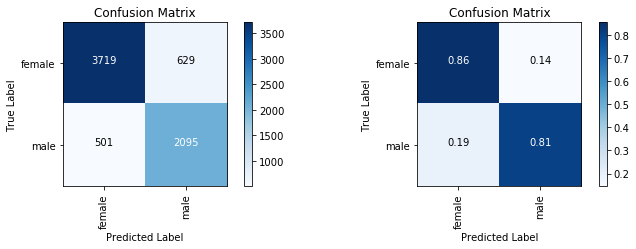

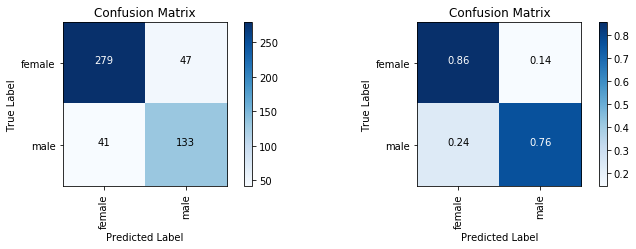

In [68]:
feat_num = 16
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb16,train_cm_nb16,train_label_names_nb16,train_report_nb16, \
    devtest_accuracy_nb16, devtest_cm_nb16,devtest_label_names_nb16, \
    devtest_report_nb16, classifier_nb16=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb16))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb16))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb16,['female','male'])

In [134]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb16)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb16)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8813    0.8553    0.8681      4348
       male     0.7691    0.8070    0.7876      2596

avg / total     0.8393    0.8373    0.8380      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8719    0.8558    0.8638       326
       male     0.7389    0.7644    0.7514       174

avg / total     0.8256    0.8240    0.8247       500



In [69]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb16.show_most_informative_features(n_informative_features)

Most Informative Features
             last2letter = u'na'          female : male   =     93.4 : 1.0
             last2letter = u'la'          female : male   =     70.0 : 1.0
              lastletter = u'k'             male : female =     39.8 : 1.0
             last2letter = u'ia'          female : male   =     38.9 : 1.0
                 has(fo) = True             male : female =     34.1 : 1.0
             last2letter = u'ra'          female : male   =     34.0 : 1.0
             last2letter = u'sa'          female : male   =     33.9 : 1.0
              lastletter = u'a'           female : male   =     32.2 : 1.0
             last3letter = u'nne'         female : male   =     28.8 : 1.0
             last2letter = u'rt'            male : female =     28.6 : 1.0
             last2letter = u'us'            male : female =     27.9 : 1.0
             last3letter = u'ana'         female : male   =     24.1 : 1.0
                 has(rk) = True             male : female =     24.0 : 1.0

In [70]:
# Show error 
show_errors(generate_errors(classifier_nb16, devtest_names, feat_num))

correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Glad       

Despite the large feature set, the performance of our model is relatively good on both the training and development test data sets.

#### Best Model for Naive Bayes Classifier  

We will now compare the best model we built using our manually constructed feature set and the feature set constructed using our optimization process.

The features selected based on the optimization process are:

In [71]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

Following features provide the most optmized solution: 
    -> First Letter                  
    -> Last Letter                   
    -> Last 2 Letters                
    -> Last 3 Letters                
    -> Vowels count                  
    -> Character count               


Accuracy (Train): 0.827764976959
Accuracy (Development Test): 0.83


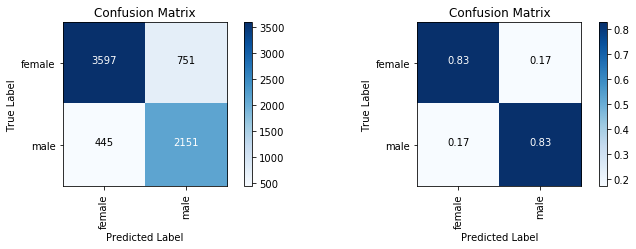

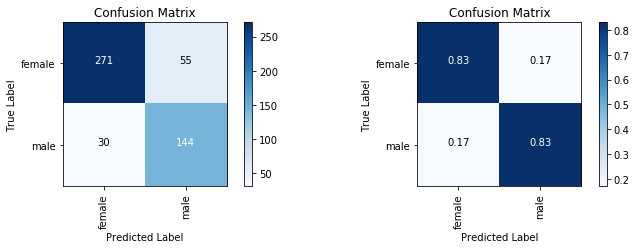

In [72]:
feat_num = [1, 3, 4, 5, 6, 11]
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb17,train_cm_nb17,train_label_names_nb17,train_report_nb17, \
    devtest_accuracy_nb17, devtest_cm_nb17,devtest_label_names_nb17, \
    devtest_report_nb17, classifier_nb17=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb17))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb17))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb17,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb17,['female','male'])

In [133]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb17)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb17)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8899    0.8273    0.8574      4348
       male     0.7412    0.8286    0.7825      2596

avg / total     0.8343    0.8278    0.8294      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.9003    0.8313    0.8644       326
       male     0.7236    0.8276    0.7721       174

avg / total     0.8388    0.8300    0.8323       500



In [73]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb17.show_most_informative_features(n_informative_features)

Most Informative Features
            last2letters = u'na'          female : male   =     93.4 : 1.0
            last2letters = u'la'          female : male   =     70.0 : 1.0
             last_letter = u'k'             male : female =     39.8 : 1.0
            last2letters = u'ia'          female : male   =     38.9 : 1.0
            last2letters = u'ra'          female : male   =     34.0 : 1.0
            last2letters = u'sa'          female : male   =     33.9 : 1.0
             last_letter = u'a'           female : male   =     32.2 : 1.0
            last3letters = u'nne'         female : male   =     28.8 : 1.0
            last2letters = u'rt'            male : female =     28.6 : 1.0
            last2letters = u'us'            male : female =     27.9 : 1.0
            last3letters = u'ana'         female : male   =     24.1 : 1.0
            last2letters = u'ld'            male : female =     23.3 : 1.0
            last2letters = u'ta'          female : male   =     22.9 : 1.0

In [74]:
# Show error 
show_errors(generate_errors(classifier_nb17, devtest_names, feat_num))

correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Britney                       
correct=female   guess=male     name=Carey                         
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Doris      

Our best manually constructed feature set (i.e., feature 16) provides slighly better results and will be the one selected for the Naive Bayes Classifier.

### Gender Identification Models - Decision Tree Classifier: 

We now evaluate how a Decision Tree classifier performs for each of our previously identified simple feature sets. 

#### Feature 1 - First Letter

In this model, we train a Decision Tree classifier using the first letter of the name.

Accuracy (Train): 0.646745391705
Accuracy (Development Test): 0.656


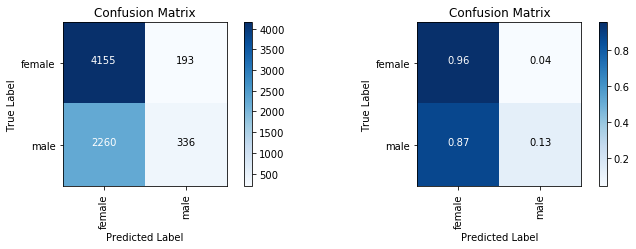

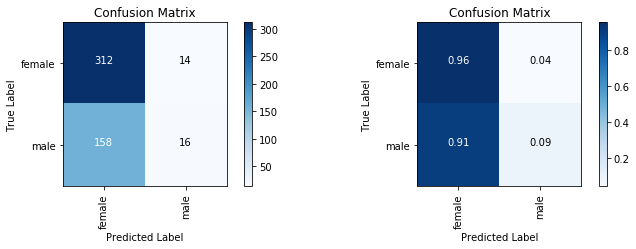

In [75]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt1,train_cm_dt1,train_label_names_dt1,train_report_dt1,devtest_accuracy_dt1, devtest_cm_dt1,devtest_label_names_dt1,devtest_report_dt1, classifier_dt1=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt1))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt1,['female','male'])

In [76]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt1)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6477    0.9556    0.7721      4348
       male     0.6352    0.1294    0.2150      2596

avg / total     0.6430    0.6467    0.5638      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6638    0.9571    0.7839       326
       male     0.5333    0.0920    0.1569       174

avg / total     0.6184    0.6560    0.5657       500



In [77]:
# Show error 
show_errors(generate_errors(classifier_dt1, devtest_names, feat_num))

correct=female   guess=male     name=Hannah                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Harli                         
correct=female   guess=male     name=Hatty                         
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Herta                         
correct=female   guess=male     name=Hilde                         
correct=female   guess=male     name=Hyacinthie                    
correct=female   guess=male     name=Quentin                       
correct=female   guess=male     name=Wilhelmine                    
correct=female   guess=male     name=Willabella                    
correct=female   guess=male     name=Willi                         
correct=female   guess=male     name=Wini                          
correct=female   guess=male     name=Yettie                        
correct=male     guess=female   name=Adlai      

#### Feature 2 - First 2 Letters  

In this model, we train a Decision Tree classifier using the first 2 letters of the name.

Accuracy (Train): 0.684907834101
Accuracy (Development Test): 0.676


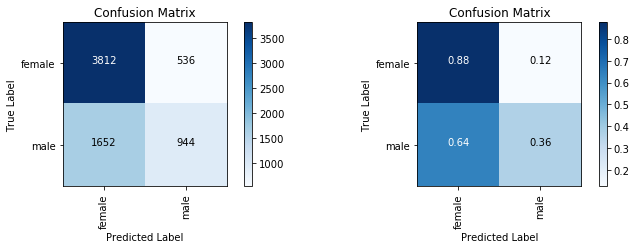

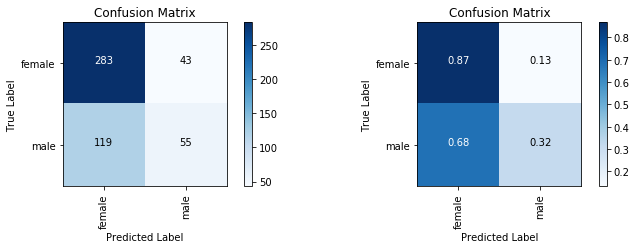

In [78]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_dt2,train_cm_dt2,train_label_names_dt2,train_report_dt2,devtest_accuracy_dt2, devtest_cm_dt2,devtest_label_names_dt2,devtest_report_dt2, classifier_dt2=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt2))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt2,['female','male'])

In [79]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt2)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt2)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6977    0.8767    0.7770      4348
       male     0.6378    0.3636    0.4632      2596

avg / total     0.6753    0.6849    0.6597      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7040    0.8681    0.7775       326
       male     0.5612    0.3161    0.4044       174

avg / total     0.6543    0.6760    0.6476       500



In [80]:
# Show error 
show_errors(generate_errors(classifier_dt2, devtest_names, feat_num))

correct=female   guess=male     name=Babette                       
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Dulcinea                      
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gayleen                       
correct=female   guess=male     name=Gianina                       
correct=female   guess=male     name=Gilli                         
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Gisella                       
correct=female   guess=male     name=Giselle                       
correct=female   guess=male     name=Grazia                        
correct=female   guess=male     name=Greta                         
correct=female   guess=male     name=Grethel                       
correct=female   guess=male     name=Hannah     

#### Feature 3 - Last Letter  

In this model, we train a Decision Tree classifier using the last letter of the name.

Accuracy (Train): 0.760512672811
Accuracy (Development Test): 0.764


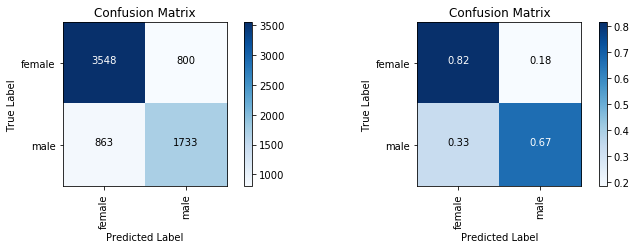

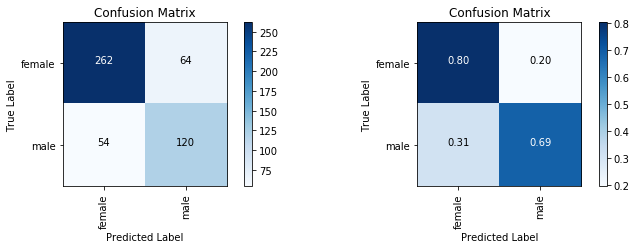

In [81]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features3
train_accuracy_dt3,train_cm_dt3,train_label_names_dt3,train_report_dt3,devtest_accuracy_dt3, devtest_cm_dt3,devtest_label_names_dt3,devtest_report_dt3, classifier_dt3=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt3))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt3,['female','male'])

In [82]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt3)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt3)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8044    0.8160    0.8101      4348
       male     0.6842    0.6676    0.6758      2596

avg / total     0.7594    0.7605    0.7599      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8291    0.8037    0.8162       326
       male     0.6522    0.6897    0.6704       174

avg / total     0.7675    0.7640    0.7655       500



In [83]:
# Show error 
show_errors(generate_errors(classifier_dt3, devtest_names, feat_num))

correct=female   guess=male     name=Ailyn                         
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Eilis                         
correct=female   guess=male     name=Ellen                         
correct=female   guess=male     name=Eryn       

#### Feature 4 - Last 2 Letters  

In this model, we train a Decision Tree classifier using the last 2 letters of the name.

Accuracy (Train): 0.802419354839
Accuracy (Development Test): 0.79


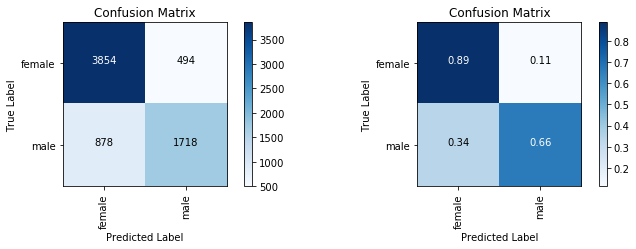

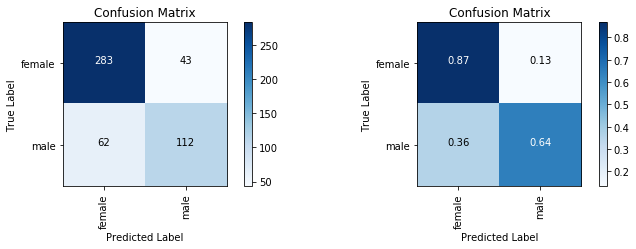

In [84]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt4,train_cm_dt4,train_label_names_dt4,train_report_dt4,devtest_accuracy_dt4, devtest_cm_dt4,devtest_label_names_dt4,devtest_report_dt4, classifier_dt4=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt4))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt4,['female','male'])

In [85]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt4)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt4)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8145    0.8864    0.8489      4348
       male     0.7767    0.6618    0.7146      2596

avg / total     0.8003    0.8024    0.7987      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8203    0.8681    0.8435       326
       male     0.7226    0.6437    0.6809       174

avg / total     0.7863    0.7900    0.7869       500



In [86]:
# Show error 
show_errors(generate_errors(classifier_dt4, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Ange                          
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger     

#### Feature 5 - Last 3 Letters  

In this model, we train a Decision Tree classifier using the last 3 letters of the name.

Accuracy (Train): 0.857430875576
Accuracy (Development Test): 0.756


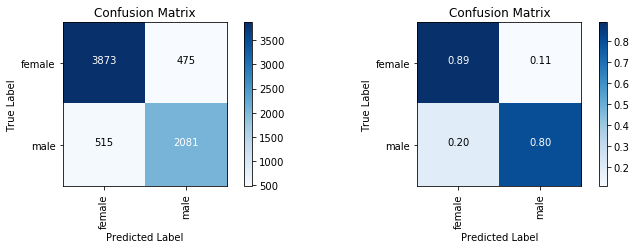

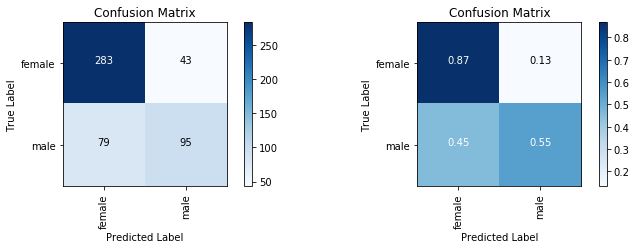

In [87]:
feat_num = 5
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt5,train_cm_dt5,train_label_names_dt5,train_report_dt5,devtest_accuracy_dt5, devtest_cm_dt5,devtest_label_names_dt5,devtest_report_dt5, classifier_dt5=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt5))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt5,['female','male'])

In [88]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt5)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt5)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8826    0.8908    0.8867      4348
       male     0.8142    0.8016    0.8078      2596

avg / total     0.8570    0.8574    0.8572      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7818    0.8681    0.8227       326
       male     0.6884    0.5460    0.6090       174

avg / total     0.7493    0.7560    0.7483       500



In [89]:
# Show error 
show_errors(generate_errors(classifier_dt5, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Beryle                        
correct=female   guess=male     name=Carey                         
correct=female   guess=male     name=Carole                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Dale                          
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Jan        

#### Feature 6 - Vowels Count  

In this model, we train a Decision Tree classifier using a vowel count the name.

Accuracy (Train): 0.628456221198
Accuracy (Development Test): 0.658


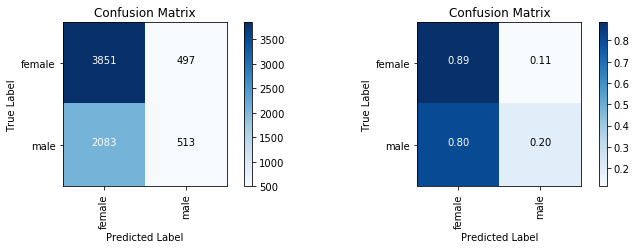

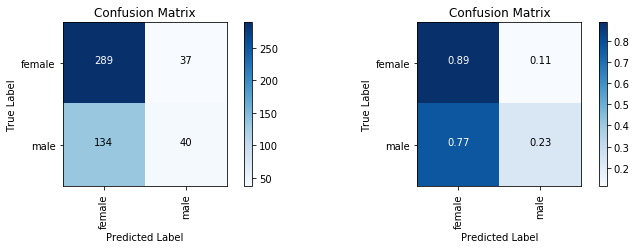

In [90]:
feat_num = 6
# evaluate the Naive Bayes classifier using gender_features6
train_accuracy_dt6,train_cm_dt6,train_label_names_dt6,train_report_dt6,devtest_accuracy_dt6, devtest_cm_dt6,devtest_label_names_dt6,devtest_report_dt6, classifier_dt6=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt6))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt6,['female','male'])

In [91]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt6)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt6)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6490    0.8857    0.7491      4348
       male     0.5079    0.1976    0.2845      2596

avg / total     0.5962    0.6285    0.5754      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6832    0.8865    0.7717       326
       male     0.5195    0.2299    0.3187       174

avg / total     0.6262    0.6580    0.6141       500



In [92]:
# Show error 
show_errors(generate_errors(classifier_dt6, devtest_names, feat_num))

correct=female   guess=male     name=Anny                          
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Deny                          
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Eryn                          
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Hatty                         
correct=female   guess=male     name=Jan        

#### Feature 7 - Hard consonants using general rules of c and g  

In this model, we train a Decision Tree classifier Hard consonants using general rules of c and g.

Accuracy (Train): 0.626440092166
Accuracy (Development Test): 0.654


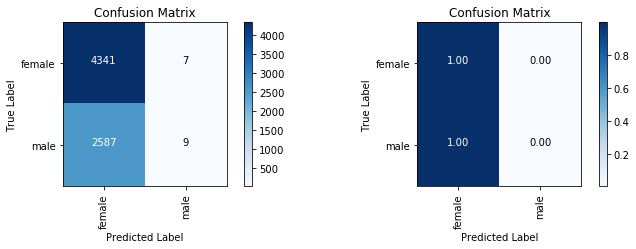

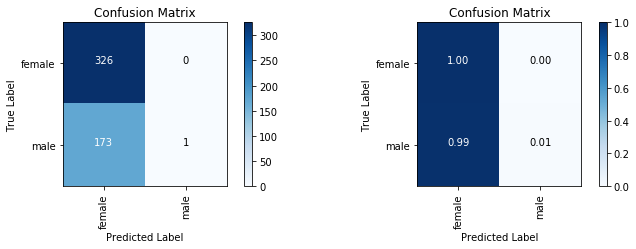

In [93]:
feat_num = 7
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt7,train_cm_dt7,train_label_names_dt7,train_report_dt7,devtest_accuracy_dt7, devtest_cm_dt7,devtest_label_names_dt7,devtest_report_dt7, classifier_dt7=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt7))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt7,['female','male'])

In [94]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt7)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt7)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6266    0.9984    0.7700      4348
       male     0.5625    0.0035    0.0069      2596

avg / total     0.6026    0.6264    0.4847      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6533    1.0000    0.7903       326
       male     1.0000    0.0057    0.0114       174

avg / total     0.7740    0.6540    0.5193       500



In [95]:
# Show error 
show_errors(generate_errors(classifier_dt7, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

#### Feature 8 - Soft Consonants  using general rules of c and g 

In this model, we train a Decision Tree classifier using soft consonants using general rules of c and g.

Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


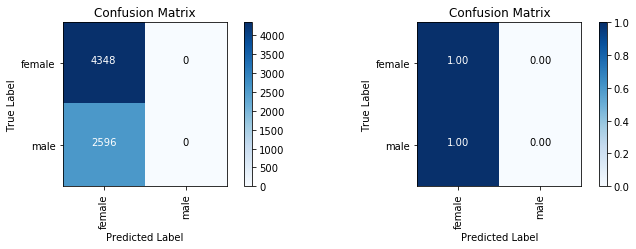

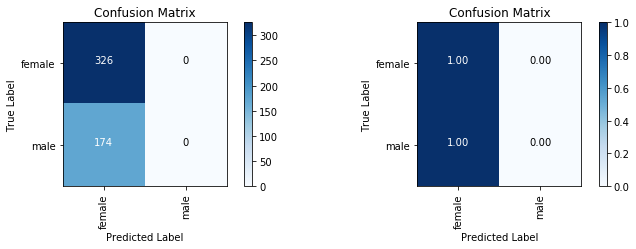

In [96]:
feat_num = 8
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt8,train_cm_dt8,train_label_names_dt8,train_report_dt8,devtest_accuracy_dt8, devtest_cm_dt8,devtest_label_names_dt8,devtest_report_dt8, classifier_dt8=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt8))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt8,['female','male'])

In [97]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt8)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt8)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6262    1.0000    0.7701      4348
       male     0.0000    0.0000    0.0000      2596

avg / total     0.3921    0.6262    0.4822      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6520    1.0000    0.7893       326
       male     0.0000    0.0000    0.0000       174

avg / total     0.4251    0.6520    0.5147       500



In [98]:
# Show error 
show_errors(generate_errors(classifier_dt8, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

#### Feature 9 - Syllable Count  

In this model, we train a Decision Tree classifier using syllable count.

Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


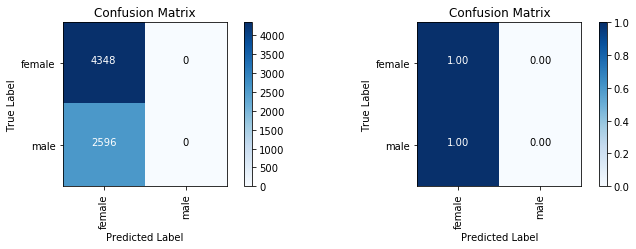

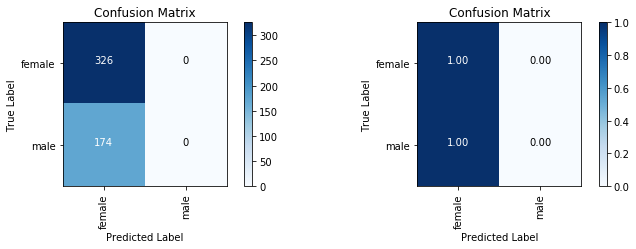

In [99]:
feat_num = 9
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt9,train_cm_dt9,train_label_names_dt9,train_report_dt9,devtest_accuracy_dt9, devtest_cm_dt9,devtest_label_names_dt9,devtest_report_dt9, classifier_dt9=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt9))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt9,['female','male'])

In [100]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt9)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt9)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6262    1.0000    0.7701      4348
       male     0.0000    0.0000    0.0000      2596

avg / total     0.3921    0.6262    0.4822      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6520    1.0000    0.7893       326
       male     0.0000    0.0000    0.0000       174

avg / total     0.4251    0.6520    0.5147       500



In [101]:
# Show error 
show_errors(generate_errors(classifier_dt9, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

#### Feature 10 - Name length  

In this model, we train a Decision Tree classifier using name length.

Accuracy (Train): 0.628744239631
Accuracy (Development Test): 0.66


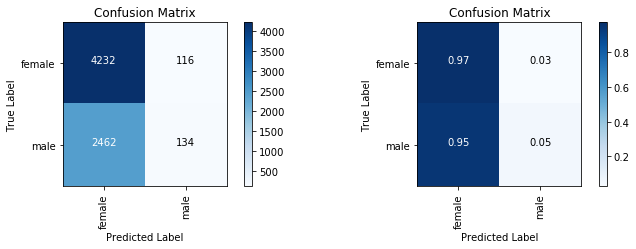

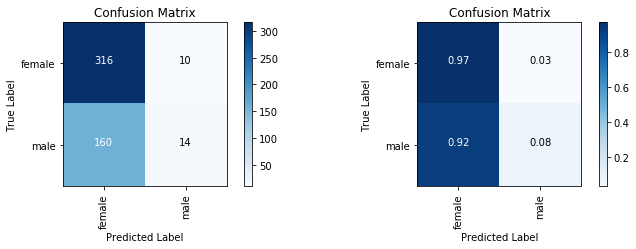

In [102]:
feat_num = 10
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt10,train_cm_dt10,train_label_names_dt10,train_report_dt10,devtest_accuracy_dt10, devtest_cm_dt10,devtest_label_names_dt10,devtest_report_dt10, classifier_dt10=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt10))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt10,['female','male'])

In [103]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt10)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt10)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6322    0.9733    0.7665      4348
       male     0.5360    0.0516    0.0942      2596

avg / total     0.5962    0.6287    0.5152      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6639    0.9693    0.7880       326
       male     0.5833    0.0805    0.1414       174

avg / total     0.6358    0.6600    0.5630       500



In [104]:
# Show error 
show_errors(generate_errors(classifier_dt10, devtest_names, feat_num))

correct=female   guess=male     name=Jan                           
correct=female   guess=male     name=Kay                           
correct=female   guess=male     name=Kia                           
correct=female   guess=male     name=Lee                           
correct=female   guess=male     name=Mag                           
correct=female   guess=male     name=May                           
correct=female   guess=male     name=Pam                           
correct=female   guess=male     name=Pen                           
correct=female   guess=male     name=Pet                           
correct=female   guess=male     name=Tim                           
correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford     

#### Feature 11 - Character Count  

In this model, we train a Decision Tree classifier using character count.

Accuracy (Train): 0.808755760369
Accuracy (Development Test): 0.69


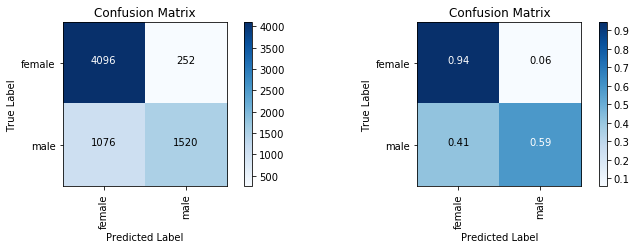

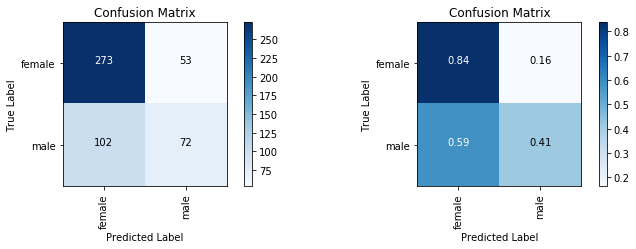

In [105]:
feat_num = 11
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt11,train_cm_dt11,train_label_names_dt11,train_report_dt11,devtest_accuracy_dt11, devtest_cm_dt11,devtest_label_names_dt11,devtest_report_dt11, classifier_dt11=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt11))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt11))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt11,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt11,['female','male'])

In [106]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt11)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt11)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7920    0.9420    0.8605      4348
       male     0.8578    0.5855    0.6960      2596

avg / total     0.8166    0.8088    0.7990      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7280    0.8374    0.7789       326
       male     0.5760    0.4138    0.4816       174

avg / total     0.6751    0.6900    0.6754       500



In [107]:
# Show error 
show_errors(generate_errors(classifier_dt11, devtest_names, feat_num))

correct=female   guess=male     name=Alberta                       
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bernardina                    
correct=female   guess=male     name=Berta                         
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Debra                         
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Eryn                          
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Florida    

#### Feature 12 - Character Present  

In this model, we train a Decision Tree classifier using character being present in name.

Accuracy (Train): 0.683323732719
Accuracy (Development Test): 0.66


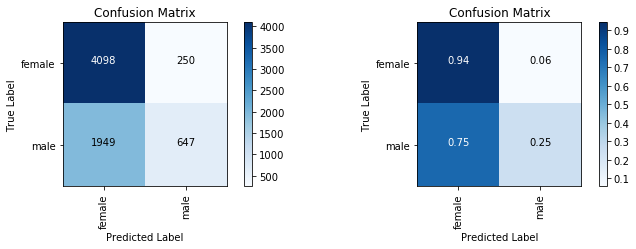

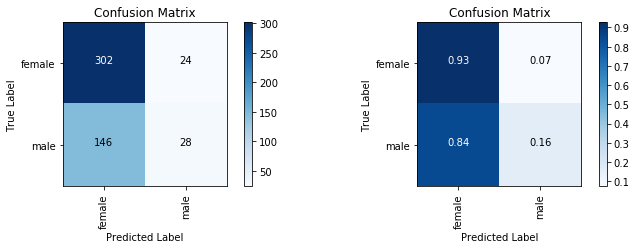

In [108]:
feat_num = 12
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt12,train_cm_dt12,train_label_names_dt12,train_report_dt12,devtest_accuracy_dt12, devtest_cm_dt12,devtest_label_names_dt12,devtest_report_dt12, classifier_dt12=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt12))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt12))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt12,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt12,['female','male'])

In [109]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt12)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt12)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6777    0.9425    0.7885      4348
       male     0.7213    0.2492    0.3705      2596

avg / total     0.6940    0.6833    0.6322      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6741    0.9264    0.7804       326
       male     0.5385    0.1609    0.2478       174

avg / total     0.6269    0.6600    0.5950       500



In [110]:
# Show error 
show_errors(generate_errors(classifier_dt12, devtest_names, feat_num))

correct=female   guess=male     name=Chiquita                      
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Eustacia                      
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Kordula                       
correct=female   guess=male     name=Pam                           
correct=female   guess=male     name=Pandora                       
correct=female   guess=male     name=Paola                         
correct=female   guess=male     name=Pen                           
correct=female   guess=male     name=Pet                           
correct=female   guess=male     name=Petronella                    
correct=female   guess=male     name=Quentin                       
correct=female   guess=male     name=Raphaela                      
correct=female   guess=male     name=Rosmunda   

#### Feature 13 - Count of each Letter  

In this model, we train a Decision Tree classifier using a count of each letter.  

Accuracy (Train): 0.809331797235
Accuracy (Development Test): 0.704


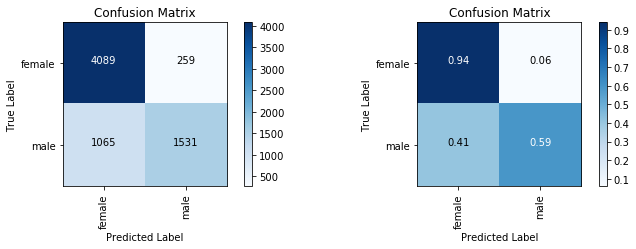

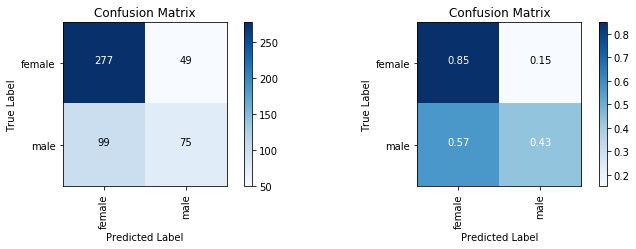

In [111]:
feat_num = 13
# evaluate the Decision Tree classifier using gender_features13
train_accuracy_dt13,train_cm_dt13,train_label_names_dt13,train_report_dt13,devtest_accuracy_dt13, devtest_cm_dt13,devtest_label_names_dt13,devtest_report_dt13, classifier_dt13=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt13))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt13))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt13,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt13,['female','male'])

In [112]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt13)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt13)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7934    0.9404    0.8607      4348
       male     0.8553    0.5898    0.6981      2596

avg / total     0.8165    0.8093    0.7999      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7367    0.8497    0.7892       326
       male     0.6048    0.4310    0.5034       174

avg / total     0.6908    0.7040    0.6897       500



In [113]:
# Show error 
show_errors(generate_errors(classifier_dt13, devtest_names, feat_num))

correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bernardina                    
correct=female   guess=male     name=Berta                         
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Debra                         
correct=female   guess=male     name=Dona                          
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Eryn                          
correct=female   guess=male     name=Esmerelda                     
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fedora     

#### Feature 14 - Count of pair of letters in the alphabet  

In this model, we train a Decision Tree classifier using count of each pair of letters in the alphabet.

Accuracy (Train): 0.802851382488
Accuracy (Development Test): 0.748


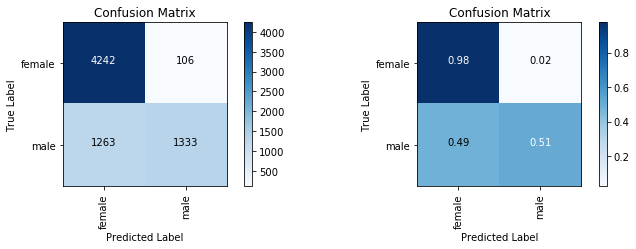

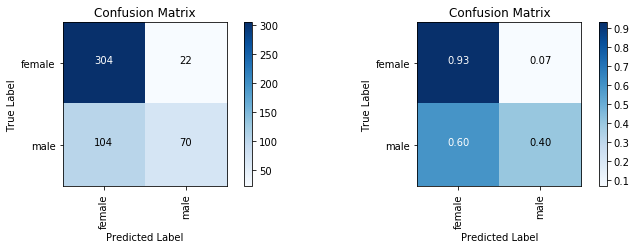

In [114]:
feat_num = 14
# evaluate the Decision Tree classifier using gender_features14
train_accuracy_dt14,train_cm_dt14,train_label_names_dt14,train_report_dt14,devtest_accuracy_dt14, devtest_cm_dt14,devtest_label_names_dt14,devtest_report_dt14, classifier_dt14=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt14))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt14))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt14,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt14,['female','male'])

In [115]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt14)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt14)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.7706    0.9756    0.8611      4348
       male     0.9263    0.5135    0.6607      2596

avg / total     0.8288    0.8029    0.7862      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7451    0.9325    0.8283       326
       male     0.7609    0.4023    0.5263       174

avg / total     0.7506    0.7480    0.7232       500



In [116]:
# Show error 
show_errors(generate_errors(classifier_dt14, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Alberta                       
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darbie                        
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Eddi                          
correct=female   guess=male     name=Eustacia                      
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Grazia                        
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Johnette                      
correct=female   guess=male     name=Kordula                       
correct=female   guess=male     name=Minerva                       
correct=female   guess=male     name=Paola      

#### Features Optimization  

In order to build the best possible Naive Bayes model, we will identify the best features based on accuracy rating.


In [117]:
ranked_features = get_sorted_feature_accuracies(1, 14, 'dtc')

In [118]:
features = {
    1: "First Letter",
    2: "First 2 Letters",
    3: "Last Letter", 
    4: "Last 2 Letters", 
    5: "Last 3 Letters", 
    6: "Vowels count",
    7: "Hard consonants using general rules of c and g",
    8: "Soft consonants using general rules of c and g",
    9: "Syllable Count of names via textstat",
    10: "Name length",
    11: "Character count",
    12: "Character present",
    13: "Count of each letter",
    14: "Count of pair of letters in the alphabet",
}

print("Top Five Single Features with the Highest Accuracy")
print("---------------------------------------------------------------")
for (feat_num, accuracy) in ranked_features[0:5]:
    print('Feature: %-30s Accuracy: %-8s' %(features[feat_num], accuracy))

print("---------------------------------------------------------------")

Top Five Single Features with the Highest Accuracy
---------------------------------------------------------------
Feature: Last 2 Letters                 Accuracy: 0.79    
Feature: Last Letter                    Accuracy: 0.764   
Feature: Last 3 Letters                 Accuracy: 0.756   
Feature: Count of pair of letters in the alphabet Accuracy: 0.748   
Feature: Count of each letter           Accuracy: 0.704   
---------------------------------------------------------------


In [119]:
optimized_features = optimized_solution('dtc')
optimized_features


([1, 2, 3, 9, 11, 12], 0.774)

We see that the optmized solution yielded an accuracy of 0.774, while the highest accuracy achieved by any single feature was 0.79. It appears as though we have a case of overfitting with our optimization using the decision tree classifier. 

We will not use this feature set for our best model using a decision tree classifier.  

The following features provided the optimized solution:

In [120]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

Following features provide the most optmized solution: 
    -> First Letter                  
    -> First 2 Letters               
    -> Last Letter                   
    -> Syllable Count of names via textstat
    -> Character count               
    -> Character present             


#### Complext Features Evaluation  

Based on the single features evaluation, we developed some complex features that we evaluate below.

##### Feature 15 - Last Letter / Last 2 Letter  

In this model, we train a Decision Tree classifier using the last letter of the name and the last two letters of a name.

Accuracy (Train): 0.802419354839
Accuracy (Development Test): 0.79


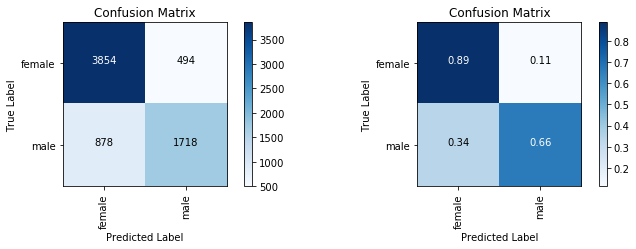

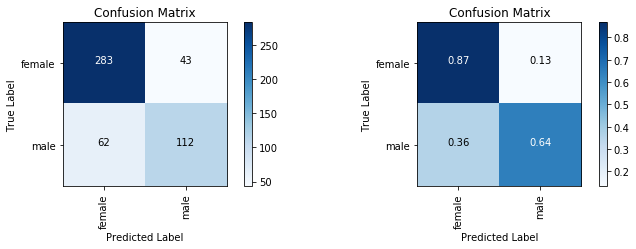

In [121]:
feat_num = 15
# evaluate the Decision Tree classifier using gender_features15
train_accuracy_dt15,train_cm_dt15,train_label_names_dt15,train_report_dt15,devtest_accuracy_dt15, devtest_cm_dt15,devtest_label_names_dt15,devtest_report_dt15, classifier_dt15=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt15))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt15))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt15,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt15,['female','male'])

In [122]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt15)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt15)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8145    0.8864    0.8489      4348
       male     0.7767    0.6618    0.7146      2596

avg / total     0.8003    0.8024    0.7987      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8203    0.8681    0.8435       326
       male     0.7226    0.6437    0.6809       174

avg / total     0.7863    0.7900    0.7869       500



In [123]:
# Show error 
show_errors(generate_errors(classifier_dt15, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Ange                          
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger     

#### Feature 16 - Complex Combination Feature  

In this model, we train a Decision Tree classifier using a feature set composed the first letter, the last letter, the last two letters, the last 3 letters, the letter count, the presence of a letter, and all two letter combinations.

Accuracy (Train): 0.953485023041
Accuracy (Development Test): 0.75


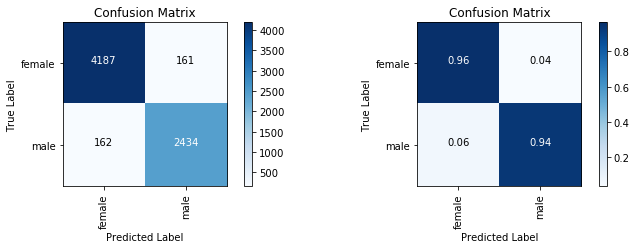

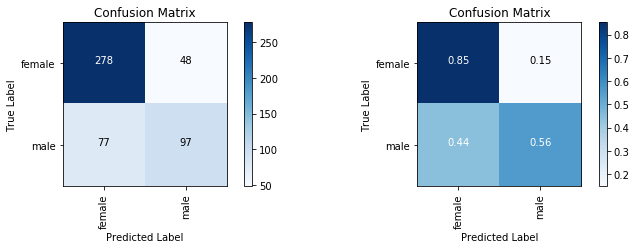

In [124]:
feat_num = 16
# evaluate the Decision Tree classifier using gender_features16
train_accuracy_dt16,train_cm_dt16,train_label_names_dt16,train_report_dt16,devtest_accuracy_dt16, devtest_cm_dt16,devtest_label_names_dt16,devtest_report_dt16, classifier_dt16=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt16))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt16))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt16,['female','male'])

In [125]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt16)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt16)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.9628    0.9630    0.9629      4348
       male     0.9380    0.9376    0.9378      2596

avg / total     0.9535    0.9535    0.9535      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.7831    0.8528    0.8164       326
       male     0.6690    0.5575    0.6082       174

avg / total     0.7434    0.7500    0.7440       500



In [126]:
# Show error 
show_errors(generate_errors(classifier_dt16, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Amie                          
correct=female   guess=male     name=Anny                          
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Beatrice                      
correct=female   guess=male     name=Beryle                        
correct=female   guess=male     name=Carey                         
correct=female   guess=male     name=Carole                        
correct=female   guess=male     name=Claude                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Dale                          
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas  

The large difference between the performance on the training and development test data sets is a clear indication of over-fitting. Recall that we generally observed a much smaller difference in the performance between the training and development test sets for Naive Bayes classifiers. This is an expected result. The overall performance of a Naive Bayes classifier can be improved with the inclusion of weak features, while the performance of the Decision Tree classifier cannot by construction.

The best results we got for the Decision Tree classifier was with combination Feature 15.  However, these results are underperform with respect to the results we got with the Naive Bayes Classifier (Feature 16).  

We will there select this model as the best.  

### Model Selection (Choose Best Candidate) 

#### Check the model's final performance on the test set. 

In [127]:
# create test set (final test)
feat_num = 16
test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
# extract actual classes (gold)
test_set_gold_nb16 = [g  for (n, g) in test_names]

# create predicted classes (test)
test_set_predictions_nb16 = [classifier_nb16.classify(get_features(n,feat_num))  for (n, g) in test_names]
# compute accuracy (test set)
test_accuracy_nb16=nltk.classify.accuracy(classifier_nb16, test_set)

# create confusion matrix
test_cm_nb16=confusion_matrix(test_set_gold_nb16, test_set_predictions_nb16)
# get unique classes (train)
test_label_names_nb16 =  list(set(test_set_gold_nb16) | set(test_set_predictions_nb16))    
# create table with precision, recall, f1-score, and support
test_report_nb16=classification_report(test_set_gold_nb16, test_set_predictions_nb16,
    digits=display_digits)

Accuracy (Train): 0.837269585253
Accuracy (Development Test): 0.824
Accuracy (Final Test): 0.804


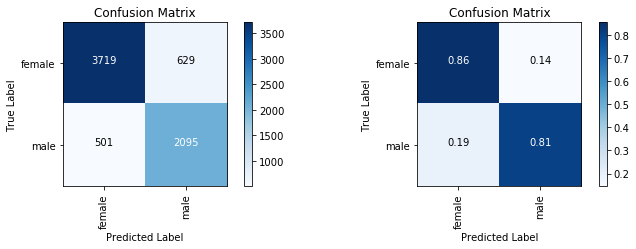

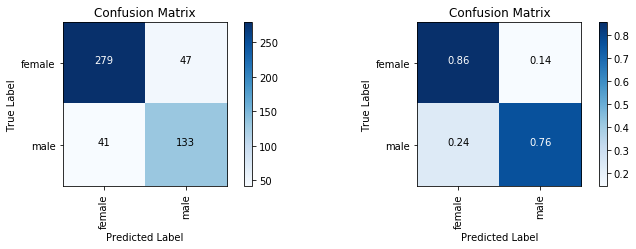

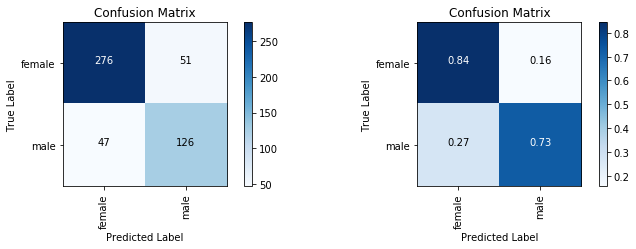

In [128]:
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb16))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb16))
print('Accuracy (Final Test): '+str(test_accuracy_nb16))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(test_cm_nb16,['female','male'])

In [129]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb16)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb16)
# display performance report (test)
print('Model Performance Metrics (Test):')
print(test_report_nb16)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.8813    0.8553    0.8681      4348
       male     0.7691    0.8070    0.7876      2596

avg / total     0.8393    0.8373    0.8380      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.8719    0.8558    0.8638       326
       male     0.7389    0.7644    0.7514       174

avg / total     0.8256    0.8240    0.8247       500

Model Performance Metrics (Test):
             precision    recall  f1-score   support

     female     0.8545    0.8440    0.8492       327
       male     0.7119    0.7283    0.7200       173

avg / total     0.8051    0.8040    0.8045       500



#### How does the performance on the test set compare to the performance on the dev-test set? 

We can see that our model performance degrades on predictions of male names as we move from the training data set to development test data set, then again from the development test data set to the final test data set. The performance degradation is less apparent on female names.

The proportion of female names is roughly the same across the training, development test, and final test data sets (62.6%, 65.2%, and 65.4% respectively). The slightly higher proportion of female names in the development test and final test data sets likely improves our performance marginally.

#### Is this what you'd expect?

We were expecting the performance results to be relatively similar across the training, development test, and final test sets.

Given that we had only two labels (i.e., female or male) to classify - and our training data set consisted of 6944 - we expected our 500-name development test set to be representative of our final test set.

Our test set balance with respect to our labels (female/male) was about 2/1.  We had female: 327 to male: 173, hence a female/male ratio of 1.89.  On our training set, we had female: 4348 to male: 2596 with a female/male ratio of 1.675.

We also expected performance on male name classification to degrade moving from development test to final test data as we observed an erosion of predictive power on male name classification moving from the training data to the test data.

### Group Project Lessons Learned

We came together very well as a group. We used www.slack.com and www.github.com to communicate and share our work.  Our efforts were a little disjointed - possibly because we came together only one week in advance of the due date of the project (thank you Karen for kick starting the project). We moved to producing code quickly with minimal group-level planning.  Had we allocated the work across the team better in the prior week, we may have been able to complete the work more efficiently.  Also, we may have been a little timid in electing a person to act as a "PM".  Finally, some members of the group had problems using GitHub and we did not fully make use of the version control features that it offered, which made compiling a final document a little bit more difficult.

#### Take-aways  
+ Some beforehand planning
+ Mastering Github